<a href="https://colab.research.google.com/github/RemyaVKarthikeyan/AA-Stagecoach-Project/blob/main/Trial_File_share_44_%2B_File_share_47.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Categorize slot function corrected


2.   SWT for next hours included

3. Dashboard overlap corrected



10/07/2024

Please enter the lineID: 145


QSI stop points for direction 145_A

   Route_Dir_QSI_No                         STOP_Name           ID
0            145_A1                     Dagenham Asda   490005922N
1            145_A2   Ballards Road / Princess Parade  490003565E2
2            145_A3                          Heathway   490008035K
3            145_A4                 Becontree Station   490000019A
4            145_A5   Martins Corner / Valence Avenue   490009704C
5            145_A6                   Longbridge Road   490009293N
6            145_A7                   Hainault Street   490007657W
7            145_A8                  High Road Ilford   490008470M
8            145_A9                 Redbridge Station   490015554C
10          145_A10  Wanstead Station  / George Green   490015125C


QSI stop points for direction 145_B

   Route_Dir_QSI_No                        STOP_Name          ID
0            145_B1              Leytonstone Station  490000137T
1            145_B2       

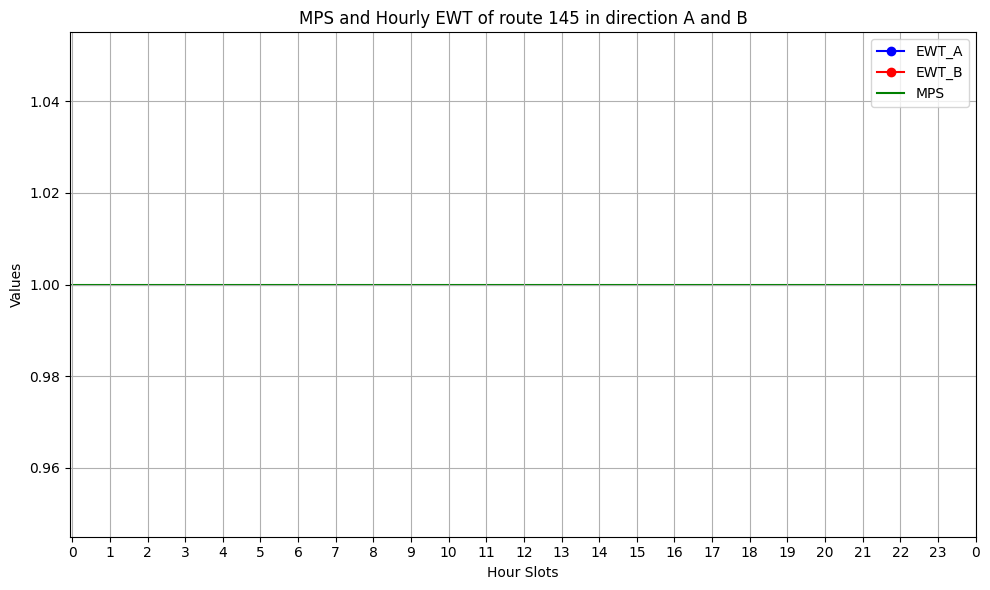



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN16OKL 490005922N  outbound    2024-07-17 12:20:10   1900-01-01 12:20:00  0.0    0.0     0.0
 145    YY66PHF 490005922N  outbound    2024-07-17 12:32:10   1900-01-01 12:32:00 12.0   24.0   144.0
 145    YY66PHJ 490005922N  outbound    2024-07-17 12:44:10   1900-01-01 12:44:00 12.0   24.0   144.0
   

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    5.0
1                           Number of buses observed    3.0
2                                      SWT (minutes)    6.0
3                                                MPS    1.0
4                                       Total_Gap_Sq  288.0
5                                        Total_2_Gap   48.0
6  Time difference between 1st and

In [2]:
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from datetime import datetime, timedelta
import pytz
import time
from IPython.display import clear_output
import numpy as np


# Initialize empty DataFrame for AWT data
awt_data = pd.DataFrame(columns=['Route_Dir_QSI_No','Stop Point ID', 'AWT','No_Buses_Obs','EWT'])
cumulative_df = pd.DataFrame()

# Function to normalize stop names
def normalize_stop_name(name):
    return ' '.join(name.lower().split())

# Function to fetch data from the API
def fetch_data(url):
    response = requests.get(url)
    return response.json()

# Function to extract schedule names
def extract_schedule_names(data, schedule_names_dict={}):
    if isinstance(data, dict):
        if data.get('$type') == "Tfl.Api.Presentation.Entities.Schedule, Tfl.Api.Presentation.Entities" and 'knownJourneys' in data:
            if 'name' in data:
                schedule_names_dict[data['name']] = data['knownJourneys']
        for key, value in data.items():
            extract_schedule_names(value, schedule_names_dict)
    elif isinstance(data, list):
        for item in data:
            extract_schedule_names(item, schedule_names_dict)
    return schedule_names_dict

# Function to categorize journeys into hourly slots
def categorize_into_slots(timetable):
    slots = [[] for _ in range(24)]
    for journey in timetable:
        hour = int(journey['hour'])  # Convert hour to integer
        slot = hour % 24  # Map hour to the correct slot
        slots[slot].append(journey)
    return slots

# Function to fetch the current day of the week
def get_day_of_week():
    bst = pytz.timezone('Europe/London')
    now = datetime.now(bst)
    return now.strftime('%A')  # %A gives full weekday name (e.g., 'Monday')

# Function to retrieve stop names from TfL API and match with Route_Dir_QSI_No
def find_route_details(lineID, df):
    # Ensure the 'Route_Dir_QSI_No' column exists
    if 'Route_Dir_QSI_No' not in df.columns:
        print("The 'Route_Dir_QSI_No' column is not present in the provided file.")
        return

    # Convert the lineID to uppercase to ensure case-insensitivity
    lineID = lineID.upper()

    # Convert the 'Route_Dir_QSI_No' column to uppercase for comparison
    df['Route_Dir_QSI_No'] = df['Route_Dir_QSI_No'].str.upper()

    # Normalize the stop names in the DataFrame
    df['STOP_NAME'] = df['STOP_NAME'].apply(normalize_stop_name)

    # Filter the DataFrame based on the lineID
    pattern_A = f"^{lineID}_A\\d+$"  # Regular expression for D7_A**
    pattern_B = f"^{lineID}_B\\d+$"  # Regular expression for D7_B**

    # Filter rows where the 'Route_Dir_QSI_No' column matches the pattern
    filtered_df_A = df[df['Route_Dir_QSI_No'].str.match(pattern_A, na=False)]
    filtered_df_B = df[df['Route_Dir_QSI_No'].str.match(pattern_B, na=False)]

    # Function to fetch and process route sequence data from TfL API
    def fetch_and_process_route_data(route_type, pattern, filtered_df):
        api_url = f"https://api.tfl.gov.uk/Line/{lineID}/Route/Sequence/{route_type}"
        response = requests.get(api_url)

        results_list = []

        if response.status_code == 200:
            route_data = response.json()

            # Iterate through each stop in the route data
            for stop in route_data['stopPointSequences'][0]['stopPoint']:
                stop_name_api = normalize_stop_name(stop['name'])
                stop_id = stop['id']

                # Check if the stop_name_api exists in the filtered DataFrame for the correct direction
                matched_row = filtered_df[(filtered_df['STOP_NAME'] == stop_name_api) &
                                          (filtered_df['Route_Dir_QSI_No'].str.match(pattern))]

                if not matched_row.empty:
                    route_dir_qsi_no = matched_row.iloc[0]['Route_Dir_QSI_No']
                    results_list.append({
                        'Route_Dir_QSI_No': route_dir_qsi_no,
                        'STOP_Name': stop['name'],
                        'ID': stop_id
                    })
                else:
                    # If exact match not found, try partial matching based on words before and after '/'
                    api_stop_name_parts = stop_name_api.split('/')
                    for index, row in filtered_df.iterrows():
                        df_stop_name_parts = row['STOP_NAME'].split('/')
                        for api_part in api_stop_name_parts:
                            for df_part in df_stop_name_parts:
                                if SequenceMatcher(None, df_part.strip(), api_part.strip()).ratio() > 0.8:
                                    matched_row = pd.DataFrame([row])
                                    break
                            if not matched_row.empty:
                                break
                        if not matched_row.empty:
                            break

                    if not matched_row.empty:
                        route_dir_qsi_no = matched_row.iloc[0]['Route_Dir_QSI_No']
                        results_list.append({
                            'Route_Dir_QSI_No': route_dir_qsi_no,
                            'STOP_Name': stop['name'],
                            'ID': stop_id
                        })
        else:
            print(f"Failed to fetch route sequence data from TfL API for {route_type} route. Status code: {response.status_code}")

        return results_list

    # Fetch and process outbound route data for _A**
    matched_results_A = fetch_and_process_route_data('outbound', pattern_A, filtered_df_A)

    # Fetch and process inbound route data for _B**
    matched_results_B = fetch_and_process_route_data('inbound', pattern_B, filtered_df_B)

    # Create DataFrames from the matched results for each direction
    matched_results_df_A = pd.DataFrame(matched_results_A)
    matched_results_df_B = pd.DataFrame(matched_results_B)

    # Function to remove partial matches if exact matches are found
    def remove_partial_matches(exact_df, matched_df):
        for index, row in exact_df.iterrows():
            exact_stop_name = row['STOP_NAME']
            route_dir_qsi_no = row['Route_Dir_QSI_No']
            # Find exact matches in matched_df
            exact_matches = matched_df[(matched_df['Route_Dir_QSI_No'] == route_dir_qsi_no) &
                                       (matched_df['STOP_Name'].apply(normalize_stop_name) == exact_stop_name)]
            if not exact_matches.empty:
                # Remove partial matches
                matched_df = matched_df[~((matched_df['Route_Dir_QSI_No'] == route_dir_qsi_no) &
                                          (matched_df['STOP_Name'].apply(normalize_stop_name) != exact_stop_name))]
        return matched_df

    # Remove partial matches for direction A
    matched_results_df_A = remove_partial_matches(filtered_df_A, matched_results_df_A)

    # Remove partial matches for direction B
    matched_results_df_B = remove_partial_matches(filtered_df_B, matched_results_df_B)

    # Remove duplicate stop names with the same Route_Dir_QSI_No and different IDs
    matched_results_df_A = matched_results_df_A.drop_duplicates(subset=['Route_Dir_QSI_No', 'STOP_Name'], keep='first')
    matched_results_df_B = matched_results_df_B.drop_duplicates(subset=['Route_Dir_QSI_No', 'STOP_Name'], keep='first')

    # Print the matched results for direction A
    print(f"\n\n\033[1m\033[4mQSI stop points for direction {lineID}_A\033[0m\n")
    matched_results_df_A = matched_results_df_A[matched_results_df_A['Route_Dir_QSI_No'].str.match(pattern_A)]
    print(matched_results_df_A[['Route_Dir_QSI_No', 'STOP_Name', 'ID']])

    # Print the matched results for direction B
    print(f"\n\n\033[1m\033[4mQSI stop points for direction {lineID}_B\033[0m\n")
    matched_results_df_B = matched_results_df_B[matched_results_df_B['Route_Dir_QSI_No'].str.match(pattern_B)]
    print(matched_results_df_B[['Route_Dir_QSI_No', 'STOP_Name', 'ID']])

    # Concatenate the matched results DataFrames for directions A and B
    combined_df = pd.concat([matched_results_df_A, matched_results_df_B], ignore_index=True)

    # DataFrames to store SWT data
    swt_data = {
        'Route_Dir_QSI_No': [],
        'ID': [],
        'SWT': [],
        'No_Buses_Sch': [],
        'SWT_hr1': [],
        'No_Buses_Sch_hr1': [],
        'SWT_hr2': [],
        'No_Buses_Sch_hr2': []
    }

    # Fetch timetable for each stop point ID and calculate SWT
    bst = pytz.timezone('Europe/London')
    current_hour = datetime.now(bst).hour
    day_of_week = get_day_of_week()

    # Store selected schedule name to ensure it's printed only once
    selected_schedule_name = None
    printed_schedule_name = False

    # Track printed timetable stop IDs
    printed_timetable_stop_ids = []

    while True:
        # Clear previous awt_data DataFrame
        awt_data = pd.DataFrame(columns=['Route_Dir_QSI_No','Stop Point ID','AWT','No_Buses_Obs','EWT'])

        # Update current time and hour
        now = datetime.now(bst)
        current_hour = now.hour
        day_of_week = get_day_of_week()

        # Clear previous SWT data
        swt_data = {
            'Route_Dir_QSI_No': [],
            'ID': [],
            'SWT': [],
            'No_Buses_Sch': [],
            'SWT_hr1': [],
            'No_Buses_Sch_hr1': [],
            'SWT_hr2': [],
            'No_Buses_Sch_hr2': []
        }

        for index, row in combined_df.iterrows():
            stop_point_id = row['ID']
            route_dir_qsi_no = row['Route_Dir_QSI_No']

            if f"{lineID}_A" in route_dir_qsi_no:
                direction = 'outbound'
            elif f"{lineID}_B" in route_dir_qsi_no:
                direction = 'inbound'
            else:
                print(f"Invalid route direction for Route_Dir_QSI_No: {route_dir_qsi_no}")
                continue

            url = f'https://api.tfl.gov.uk/Line/{lineID}/Timetable/{stop_point_id}?direction={direction}'
            data = fetch_data(url)

            schedule_names_dict = extract_schedule_names(data)

            if not selected_schedule_name:
                if day_of_week.lower() in ['monday', 'tuesday', 'wednesday', 'thursday']:
                    preferred_schedule_names = ['Mon-Fri Schooldays', 'Monday to Thursday', 'Monday to Friday']
                elif day_of_week.lower() == 'friday':
                    preferred_schedule_names = ['Mon-Fri Schooldays', 'Monday to Friday', 'Friday']
                elif day_of_week.lower() == 'saturday':
                    preferred_schedule_names = ['Saturday']
                elif day_of_week.lower() == 'sunday':
                    preferred_schedule_names = ['Sunday']
                else:
                    preferred_schedule_names = [day_of_week]

                for preferred_name in preferred_schedule_names:
                    if preferred_name in schedule_names_dict:
                        selected_schedule_name = preferred_name
                        break

            if selected_schedule_name and not printed_schedule_name:
                print(f"\nToday is {day_of_week}. The selected Schedule name is {selected_schedule_name}.")
                printed_schedule_name = True

            if selected_schedule_name:
                timetable = schedule_names_dict[selected_schedule_name]
                slots = categorize_into_slots(timetable)

                # Calculate Scheduled Wait Time (SWT)
                total_buses_this_hour = len(slots[current_hour])
                scheduled_wait_time = 60 / (total_buses_this_hour * 2) if total_buses_this_hour > 0 else float('inf')
                next_hour = (current_hour + 1) % 24  # Wrap around using modulo operator
                total_buses_hr1 = len(slots[next_hour])
                scheduled_wait_time_hr1 = 60 / (total_buses_hr1 * 2) if total_buses_hr1 > 0 else float('inf')
                next_next_hour = (current_hour + 2) % 24  # Wrap around using modulo operator
                total_buses_hr2 = len(slots[next_next_hour])
                scheduled_wait_time_hr2 = 60 / (total_buses_hr2 * 2) if total_buses_hr2 > 0 else float('inf')

                # Store SWT data
                swt_data['Route_Dir_QSI_No'].append(route_dir_qsi_no)
                swt_data['ID'].append(stop_point_id)
                swt_data['SWT'].append(scheduled_wait_time)
                swt_data['No_Buses_Sch'].append(total_buses_this_hour)
                swt_data['SWT_hr1'].append(scheduled_wait_time_hr1)
                swt_data['No_Buses_Sch_hr1'].append(total_buses_hr1)
                swt_data['SWT_hr2'].append(scheduled_wait_time_hr2)
                swt_data['No_Buses_Sch_hr2'].append(total_buses_hr2)
                # Fetch arrival predictions based on SWT data for printed timetable stop IDs
                if stop_point_id in printed_timetable_stop_ids:
                    # Fetch arrival predictions
                    arrival_predictions_df, station_name = fetch_arrival_predictions(lineID, stop_point_id, direction)

                    if arrival_predictions_df is not None and not arrival_predictions_df.empty:
                        print(f"\nArrival Predictions for stop point {stop_point_id} ({station_name}):")
                        print(arrival_predictions_df.to_string(index=False))
                        print(f"   ")
                        # Calculating summary metrics
                        total_Gap_Sq = arrival_predictions_df['Gap_Sq'].sum()
                        total_2_Gap = arrival_predictions_df['2_Gap'].sum()
                        min_arrival = arrival_predictions_df['Expected Arrival (BST)'].min().replace(second=0, microsecond=0)
                        max_arrival = arrival_predictions_df['Expected Arrival (BST)'].max().replace(second=0, microsecond=0)
                        time_diff_minutes = (max_arrival - min_arrival).total_seconds() / 60
                        num_buses_observed = arrival_predictions_df['Vehicle ID'].nunique()

                        # Calculating AWT, SWT, and EWT
                        nbph = swt_data['No_Buses_Sch'][swt_data['ID'].index(stop_point_id)]
                        swt = swt_data['SWT'][swt_data['ID'].index(stop_point_id)]
                        awt = round(total_Gap_Sq / total_2_Gap, 2) if total_2_Gap > 0 else 0
                        ewt = round(awt - swt, 2)
                        MPS = filtered_data['MPS'].iloc[0]
                        ewt_var = round(ewt - MPS,2)
                        summary_df = pd.DataFrame({
                            'Metric': ['Number of buses scheduled per hour (nbph)', 'Number of buses observed', 'SWT (minutes)','MPS', 'Total_Gap_Sq', 'Total_2_Gap',
                                       'Time difference between 1st and last observed buses (minutes)', 'AWT (minutes)', 'EWT (minutes)', 'EWT Variance'],
                            'Value': [nbph, num_buses_observed, swt, MPS, total_Gap_Sq, total_2_Gap, time_diff_minutes, awt, ewt, ewt_var]
                        })
                        print(f"\nSummary Metrics for {stop_point_id}:")
                        print(summary_df)

                        # Append to awt_data DataFrame
                        awt_data.loc[len(awt_data)] = [swt_data['Route_Dir_QSI_No'][swt_data['ID'].index(stop_point_id)],stop_point_id, awt,num_buses_observed,ewt]

                    # Remove the stop ID from printed_timetable_stop_ids to avoid redundant fetches
                    printed_timetable_stop_ids.remove(stop_point_id)

        # Update printed timetable stop IDs
        printed_timetable_stop_ids = swt_data['ID']

        # Create DataFrame for SWT data
        swt_df = pd.DataFrame(swt_data)
        awt_df = pd.DataFrame(awt_data)
        # Print the SWT DataFrame
        print(f"\n\n\033[1m\033[4mSWT DataFrame at hour {current_hour}\033[0m\n")
        print(swt_df)

        print(f"\n\n\033[1m\033[4mAWT DataFrame at hour {now.strftime('%H:%M')}\033[0m\n")
        print(awt_df)

        def update_hourly_EWT(hourly_EWT, current_hour, next_hour, lineID, avg_ewt_A, avg_ewt_B):
            # Create the hour slot string
            hour_slot = f"{current_hour}:00 - {next_hour}:00"

            # Create a new entry as a DataFrame
            new_entry = pd.DataFrame({
                'Hour slot': [hour_slot],
                'Line ID': [lineID],
                'EWT_A': [round(avg_ewt_A, 2) if avg_ewt_A is not None else None],
                'EWT_B': [round(avg_ewt_B, 2) if avg_ewt_B is not None else None]
            })

            # If hourly_EWT is empty, return the new entry as the DataFrame
            if hourly_EWT.empty:
                return new_entry

            # Check if there is an existing row with the same Hour slot and Line ID
            condition = (hourly_EWT['Hour slot'] == hour_slot) & (hourly_EWT['Line ID'] == lineID)

            if condition.any():
                # Update the existing row
                if avg_ewt_A is not None:
                    hourly_EWT.loc[condition, 'EWT_A'] = round(avg_ewt_A, 2)
                if avg_ewt_B is not None:
                    hourly_EWT.loc[condition, 'EWT_B'] = round(avg_ewt_B, 2)
            else:
                # Append the new entry to the DataFrame
                hourly_EWT = pd.concat([hourly_EWT, new_entry], ignore_index=True)

            return hourly_EWT

        def calculate_route_swt_awt(swt_df, awt_df):

            # Filter the swt_df to include only rows where Route_Dir_QSI_No matches the pattern _A** and _B**
            filtered_df_A_swt = swt_df[swt_df['Route_Dir_QSI_No'].str.contains('_A')].copy()
            filtered_df_B_swt = swt_df[swt_df['Route_Dir_QSI_No'].str.contains('_B')].copy()

            # Calculate the product of SWT and No_Buses_Sch for each row
            filtered_df_A_swt.loc[:, 'SWT_No_Buses_Sch_Product_A'] = filtered_df_A_swt['SWT'] * filtered_df_A_swt['No_Buses_Sch'].copy()
            filtered_df_B_swt.loc[:, 'SWT_No_Buses_Sch_Product_B'] = filtered_df_B_swt['SWT'] * filtered_df_B_swt['No_Buses_Sch'].copy()

            # Find the sum of these products (Route SWT)
            sum_products_A_swt = filtered_df_A_swt.loc[:, 'SWT_No_Buses_Sch_Product_A'].sum()
            sum_products_B_swt = filtered_df_B_swt.loc[:, 'SWT_No_Buses_Sch_Product_B'].sum()

            # Calculate the total sum of No_Buses_Sch for the filtered rows
            total_no_buses_sch_A_swt = filtered_df_A_swt.loc[:, 'No_Buses_Sch'].sum()
            total_no_buses_sch_B_swt = filtered_df_B_swt.loc[:, 'No_Buses_Sch'].sum()

            # Compute the Route SWT (direction A)
            route_swt_direction_A = sum_products_A_swt / total_no_buses_sch_A_swt if total_no_buses_sch_A_swt > 0 else 0
            route_swt_direction_B = sum_products_B_swt / total_no_buses_sch_B_swt if total_no_buses_sch_B_swt > 0 else 0

            # Round the results to two decimal places
            route_swt_direction_A = round(route_swt_direction_A, 2)
            route_swt_direction_B = round(route_swt_direction_B, 2)

            # Initialize route_awt_direction_A and route_awt_direction_B
            route_awt_direction_A = 0
            route_awt_direction_B = 0
            route_ewt_direction_A = 0
            route_ewt_direction_B = 0

            if not awt_df.empty:
                # Filter the awt_df to include only rows where Route_Dir_QSI_No matches the pattern _A** and _B**
                filtered_df_A_awt = awt_df[awt_df['Route_Dir_QSI_No'].str.contains('_A')].copy()
                filtered_df_B_awt = awt_df[awt_df['Route_Dir_QSI_No'].str.contains('_B')].copy()

                # Calculate the product of AWT and No_Buses_Obs for each row
                filtered_df_A_awt.loc[:, 'AWT_No_Buses_Obs_Product_A'] = filtered_df_A_awt['AWT'] * filtered_df_A_awt['No_Buses_Obs'].copy()
                filtered_df_B_awt.loc[:, 'AWT_No_Buses_Obs_Product_B'] = filtered_df_B_awt['AWT'] * filtered_df_B_awt['No_Buses_Obs'].copy()

                # Find the sum of these products (Route AWT)
                sum_products_A_awt = filtered_df_A_awt.loc[:, 'AWT_No_Buses_Obs_Product_A'].sum()
                sum_products_B_awt = filtered_df_B_awt.loc[:, 'AWT_No_Buses_Obs_Product_B'].sum()

                # Calculate the total sum of No_Buses_Obs for the filtered rows
                total_no_buses_obs_A_awt = filtered_df_A_awt.loc[:, 'No_Buses_Obs'].sum()
                total_no_buses_obs_B_awt = filtered_df_B_awt.loc[:, 'No_Buses_Obs'].sum()

                # Compute the Route AWT (direction A)
                route_awt_direction_A = sum_products_A_awt / total_no_buses_obs_A_awt if total_no_buses_obs_A_awt > 0 else 0
                route_awt_direction_B = sum_products_B_awt / total_no_buses_obs_B_awt if total_no_buses_obs_B_awt > 0 else 0

                # Round the results to two decimal places
                route_awt_direction_A = round(route_awt_direction_A, 2)
                route_awt_direction_B = round(route_awt_direction_B, 2)

                # Calculate Route EWT (direction A and B)
                route_ewt_direction_A = round(route_awt_direction_A - route_swt_direction_A, 2)
                route_ewt_direction_B = round(route_awt_direction_B - route_swt_direction_B, 2)

                # Prepare Route_EWT_df
                route_EWT_df = pd.DataFrame([
                    {'Time': now.strftime('%H:%M'), 'Line Id': lineID, 'Direction': 'A', 'SWT': route_swt_direction_A, 'AWT': route_awt_direction_A, 'EWT': route_ewt_direction_A},
                    {'Time': now.strftime('%H:%M'), 'Line Id': lineID, 'Direction': 'B', 'SWT': route_swt_direction_B, 'AWT': route_awt_direction_B, 'EWT': route_ewt_direction_B}
                ])

                # Print the results in the desired format
                print(f"\n\033[1m\033[4mRoute SWT, AWT, EWT at this instant  : {now.strftime('%H:%M')}\033[0m\n")
                print(route_EWT_df[['Time', 'Line Id', 'Direction', 'SWT', 'AWT', 'EWT']].to_string(index=False))

            else:
                # If awt_df is empty, print only SWT and indicate that AWT and EWT could not be calculated

                route_EWT_df = pd.DataFrame([
                    {'Time': now.strftime('%H:%M'), 'Line Id': lineID, 'Direction': 'A', 'SWT': route_swt_direction_A, 'AWT': '-', 'EWT': '-'},
                    {'Time': now.strftime('%H:%M'), 'Line Id': lineID, 'Direction': 'B', 'SWT': route_swt_direction_B, 'AWT': '-', 'EWT': '-'}
                ])
                print(f"\n\033[1m\033[4mRoute {lineID} SWT, AWT, EWT at this instant : {now.strftime('%H:%M')}\033[0m\n")
                print(route_EWT_df[['Time', 'Line Id', 'Direction', 'SWT', 'AWT', 'EWT']].to_string(index=False))
                print(f"\n\033[1m\033[4mUnable to calculate Route AWT and EWT for direction A and B as the AWT dataframe is not ready\033[0m\n")

            return route_EWT_df

        def append_route_EWT_df_to_csv(route_EWT_df, csv_file_path='/content/route_ewt.csv'):
            # Check if the CSV files for directions A and B exist
            csv_file_path_A = '/content/route_EWT_A.csv'
            csv_file_path_B = '/content/route_EWT_B.csv'

            # Check if the CSV files exist
            file_exists_A = os.path.isfile(csv_file_path_A)
            file_exists_B = os.path.isfile(csv_file_path_B)

            # Split the DataFrame based on 'Direction' column
            route_EWT_A_df = route_EWT_df[route_EWT_df['Direction'] == 'A']
            route_EWT_B_df = route_EWT_df[route_EWT_df['Direction'] == 'B']

            # Append the DataFrame to the respective CSV files
            route_EWT_A_df.to_csv(csv_file_path_A, mode='a', header=not file_exists_A, index=False)
            route_EWT_B_df.to_csv(csv_file_path_B, mode='a', header=not file_exists_B, index=False)

            print(f"Data appended to {csv_file_path_A} and {csv_file_path_B}")

        def calculate_average_ewt(route_EWT_A_csv, route_EWT_B_csv, lineID, hourly_EWT):

            current_hour = now.strftime('%H')
            current_hour_int = int(current_hour)
            next_hour_int = current_hour_int + 1
            next_hour = str(next_hour_int)

            # Read CSV files into DataFrames with different names
            df_A = pd.read_csv(route_EWT_A_csv)
            df_B = pd.read_csv(route_EWT_B_csv)

            # Filter df_A for valid EWT and matching time
            ewt_A_filtered = df_A[(df_A['EWT'] != '-') & (df_A['Time'].str[:2] == current_hour) & (df_A['Line Id'] == lineID)].copy()
            ewt_A_filtered.loc[:, 'EWT'] = pd.to_numeric(ewt_A_filtered['EWT'], errors='coerce')

            # Calculate average EWT for direction A
            if len(ewt_A_filtered) > 0:
                ewt_A_filtered['EWT'] = pd.to_numeric(ewt_A_filtered['EWT'], errors='coerce')
                total_ewt_A = ewt_A_filtered['EWT'].sum()
                count_ewt_A = len(ewt_A_filtered)
                avg_ewt_A = total_ewt_A / count_ewt_A
            else:
                avg_ewt_A = None

            # Filter df_B for valid EWT and matching time
            ewt_B_filtered = df_B[(df_B['EWT'] != '-') & (df_B['Time'].str[:2] == current_hour) & (df_B['Line Id'] == lineID)].copy()
            ewt_B_filtered.loc[:, 'EWT'] = pd.to_numeric(ewt_B_filtered['EWT'], errors='coerce')

            # Calculate average EWT for direction B
            if len(ewt_B_filtered) > 0:
                ewt_B_filtered['EWT'] = pd.to_numeric(ewt_B_filtered['EWT'], errors='coerce')
                total_ewt_B = ewt_B_filtered['EWT'].sum()
                count_ewt_B = len(ewt_B_filtered)
                avg_ewt_B = total_ewt_B / count_ewt_B
            else:
                avg_ewt_B = None

            # Print the results
            print(f"\n\033[1m\033[4mHourly EWT for time {current_hour}:00 - {next_hour}:00\033[0m\n")

            if avg_ewt_A is not None:
                print(f"Direction A: {avg_ewt_A:.2f} minutes")
            else:
                print("Direction A: No valid data found")

            if avg_ewt_B is not None:
                print(f"Direction B: {avg_ewt_B:.2f} minutes")
            else:
                print("Direction B: No valid data found")

            # Update the hourly_EWT DataFrame
            hourly_EWT = update_hourly_EWT(hourly_EWT, current_hour, next_hour, lineID, avg_ewt_A, avg_ewt_B)

            return hourly_EWT

        # Main execution

        # Assuming swt_df, awt_df, and lineID are already defined
        route_EWT_df = calculate_route_swt_awt(swt_df, awt_df)
        append_route_EWT_df_to_csv(route_EWT_df, csv_file_path='/content/route_ewt.csv')
        if 'hourly_EWT' not in locals():
            # Initialize an empty DataFrame for hourly_EWT
            hourly_EWT = pd.DataFrame(columns=['Hour slot', 'Line ID', 'EWT_A', 'EWT_B'])
        else:
            # Optionally, you may choose to clear the existing DataFrame
            # hourly_EWT = pd.DataFrame(columns=['Hour slot', 'Line ID', 'EWT_A', 'EWT_B'])
            pass
        # Calculate average EWT and update hourly_EWT DataFrame
        hourly_EWT = calculate_average_ewt('route_EWT_A.csv', 'route_EWT_B.csv', lineID, hourly_EWT)
        print(f"\n\n\033[1m\033[4mHourly EWT DataFrame\033[0m\n")
        print(hourly_EWT)
        hourly_EWT.to_csv('/content/hourly_EWT.csv', index=False)
        print("DataFrame saved to 'hourly_EWT.csv'")

        lineID_sheet2 = str(lineID)
        df_sheet2['Route'] = df_sheet2['Route'].astype(str)
        filtered_data = df_sheet2[(df_sheet2['Route'] == lineID_sheet2) | (df_sheet2['Route'] == line_id_input)]

        # Function to extract start hour from 'Hour slot'
        def extract_start_hour(hour_slot):
            return int(hour_slot[:2])

        # Extracting the start hour for each row
        hourly_EWT['start_hour'] = hourly_EWT['Hour slot'].apply(extract_start_hour)
        MPS = filtered_data['MPS'].iloc[0]

        # Plotting
        plt.figure(figsize=(10, 6))

        for index, row in hourly_EWT.iterrows():
            start_hour = row['start_hour']
            end_hour = start_hour + 1

            # Plotting EWT_A
            plt.plot([start_hour, end_hour], [row['EWT_A'], row['EWT_A']], marker='o', linestyle='-', color='b', label='EWT_A' if index == 0 else "", zorder=3)

            # Plotting EWT_B
            plt.plot([start_hour, end_hour], [row['EWT_B'], row['EWT_B']], marker='o', linestyle='-', color='r', label='EWT_B' if index == 0 else "", zorder=2)

        plt.axhline(y=MPS, color='g', linestyle='-', label='MPS', zorder=1)
        plt.title(f'MPS and Hourly EWT of route {lineID} in direction A and B')
        plt.xlabel('Hour Slots')
        plt.ylabel('Values')
        hours = list(range(24)) + [0]  # Add 0 after 23 for x-axis label
        plt.xticks(range(25), hours)  # Set x-axis ticks and labels
        plt.legend()  # Show legend
        plt.grid(True)
        plt.tight_layout()
        plt.show()


        # Wait for the next 30 seconds
        #clear_output(wait=True)
        print("\n\nWaiting to fetch updated data...\n\n")
        time.sleep(15)
        #clear_output(wait=True)

# Function to fetch arrival predictions with error handling
def fetch_arrival_predictions(line_id, stop_point_id, direction):
    try:
        base_url = f"https://api.tfl.gov.uk/Line/{line_id}/Arrivals/{stop_point_id}"
        params = {'direction': direction}
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        if len(data) == 0:
            return pd.DataFrame(), None  # No data available
        station_name = data[0]['stationName']
        predictions = []
        for item in data:
            arrival_time = datetime.strptime(item['expectedArrival'], '%Y-%m-%dT%H:%M:%SZ')
            arrival_time_bst = arrival_time + timedelta(hours=1)
            predictions.append({
                'Line': item['lineName'],
                'Vehicle ID': item['vehicleId'],
                'Stop Point': stop_point_id,
                'Direction': direction,
                'Expected Arrival (BST)': arrival_time_bst,
                'Expected Arrival (HM)': arrival_time_bst.strftime('%H:%M')
            })
        df = pd.DataFrame(predictions)
        df = df.sort_values(by='Expected Arrival (BST)', ascending=True)
        df['Expected Arrival (BST)'] = pd.to_datetime(df['Expected Arrival (BST)'])  # Convert to datetime
        df['Expected Arrival (HM)'] = pd.to_datetime(df['Expected Arrival (HM)'], format='%H:%M')
        df['Gap'] = df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
        df['2_Gap'] = (df['Gap'] * 2).round(2)
        df['Gap_Sq'] = (df['Gap'] * df['Gap']).round(2)
        return df, station_name
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None, None
        time.sleep(15)  # Wait for 30 seconds before fetching data again
# Example usage
if __name__ == "__main__":
    # Load the Excel file into a DataFrame
    file_path = '/content/QSI points.xlsx'  # Modify this path accordingly
    df = pd.read_excel(file_path)
    df_sheet2 = pd.read_excel(file_path, sheet_name='Sheet2')


    # Ask the user to enter a lineID
    line_id_input = input("Please enter the lineID: ")
    lineID_sheet2 = str(line_id_input.upper())
    df_sheet2['Route'] = df_sheet2['Route'].astype(str)
    filtered_data = df_sheet2[(df_sheet2['Route'] == lineID_sheet2) | (df_sheet2['Route'] == line_id_input)]
    while True:
        try:
            # Find and display the route details
            find_route_details(line_id_input, df)

            time.sleep(15)

        except KeyboardInterrupt:
            print("\n\nExecution interrupted. Exiting the loop.\n")
            break

Modification - 17/07/2024 - 44+ 47

Please enter the lineID: 145


QSI stop points for direction 145_A

   Route_Dir_QSI_No                         STOP_Name           ID
0            145_A1                     Dagenham Asda   490005922N
1            145_A2   Ballards Road / Princess Parade  490003565E2
2            145_A3                          Heathway   490008035K
3            145_A4                 Becontree Station   490000019A
4            145_A5   Martins Corner / Valence Avenue   490009704C
5            145_A6                   Longbridge Road   490009293N
6            145_A7                   Hainault Street   490007657W
7            145_A8                  High Road Ilford   490008470M
8            145_A9                 Redbridge Station   490015554C
10          145_A10  Wanstead Station  / George Green   490015125C


QSI stop points for direction 145_B

   Route_Dir_QSI_No                        STOP_Name          ID
0            145_B1              Leytonstone Station  490000137T
1            145_B2       

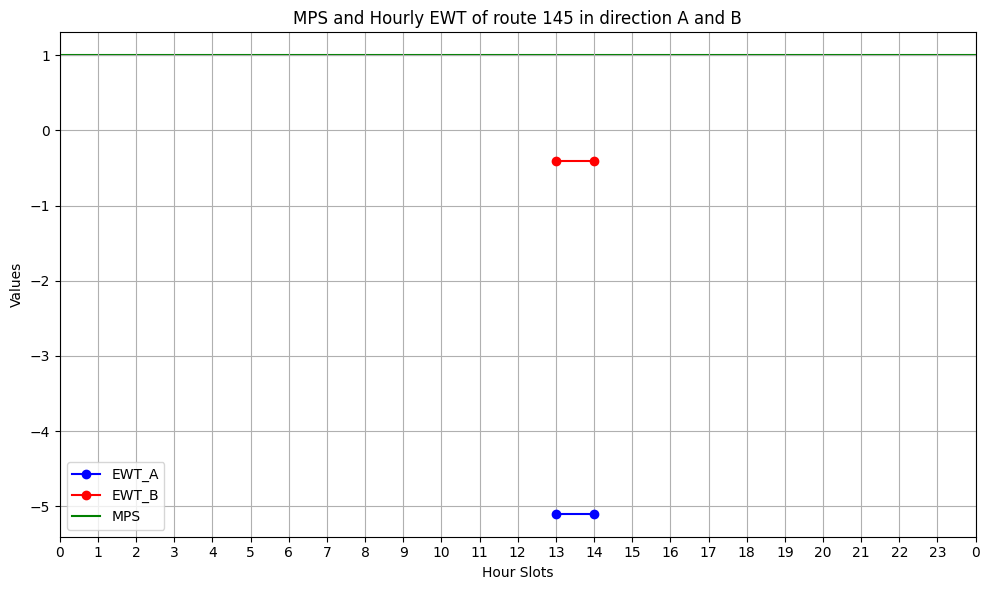



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Number of buses observed in the current hour: 0

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    5.0
1                           Number of buses observed    2.0
2 

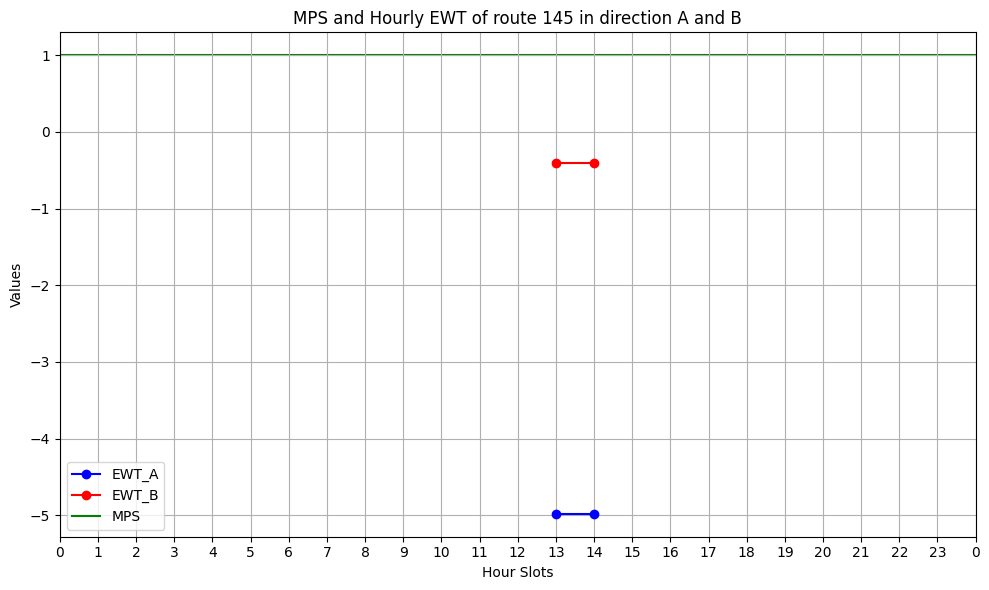



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Number of buses observed in the current hour: 0

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    5.0
1                           Number of buses observed    2.0
2 

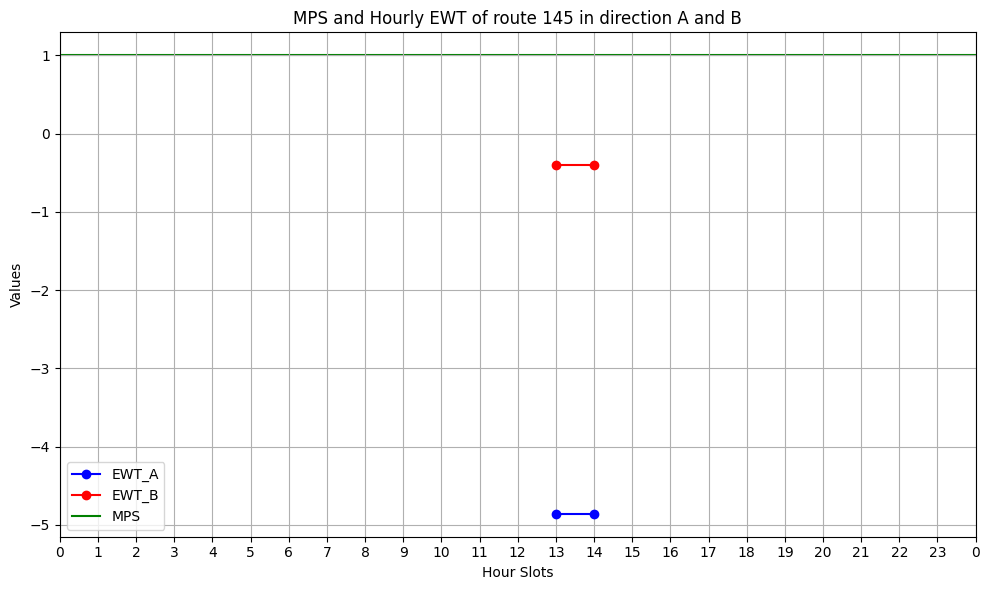



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Number of buses observed in the current hour: 0

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    5.0
1                           Number of buses observed    2.0
2 

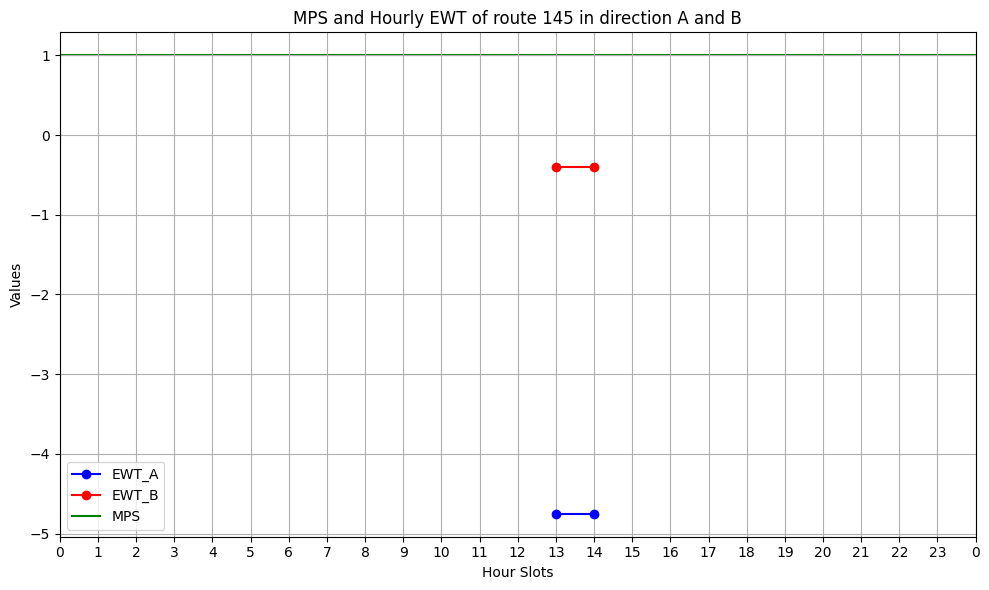



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    5.0
1                           Number of buses observed    2.0
2 

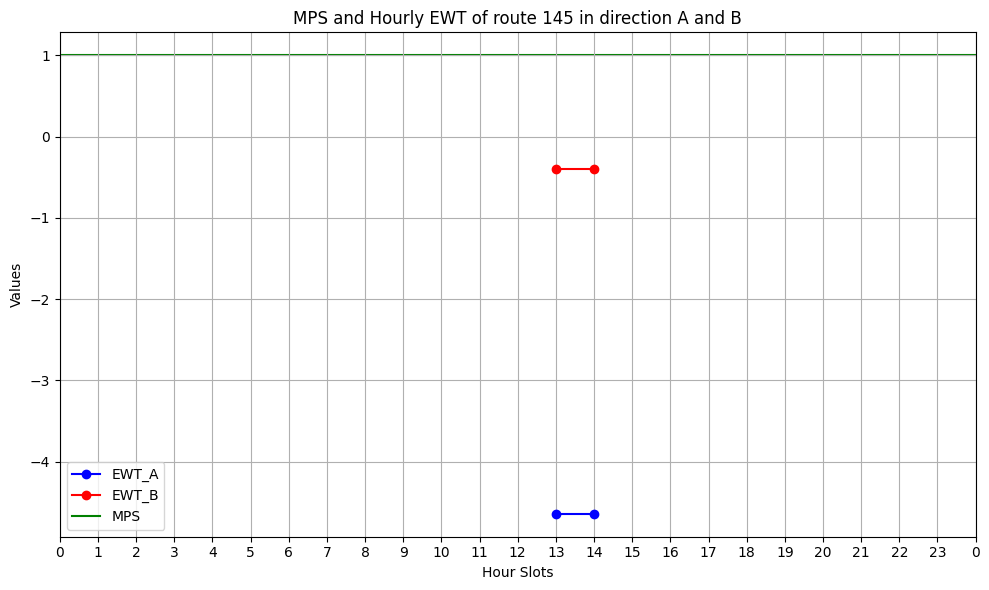



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

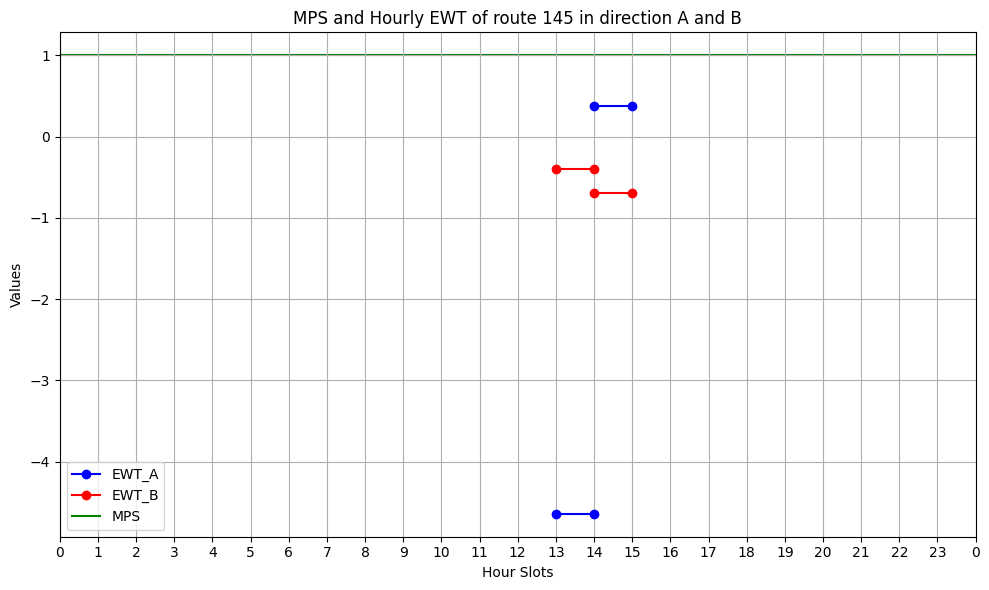



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 3

Summary Me

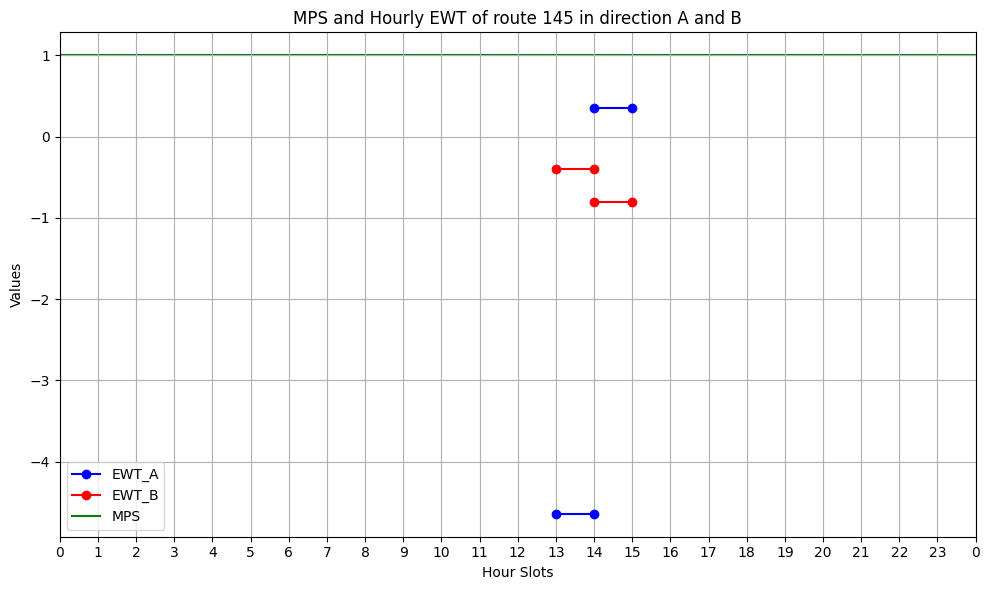



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 3

Summary Me

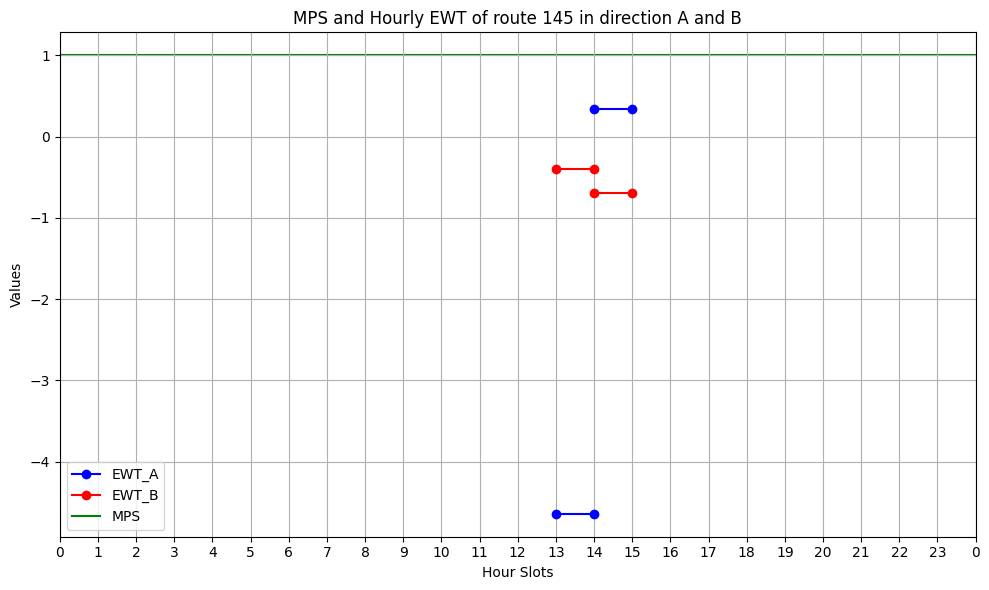



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00 12.0   24.0   144.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 3

Summary Me

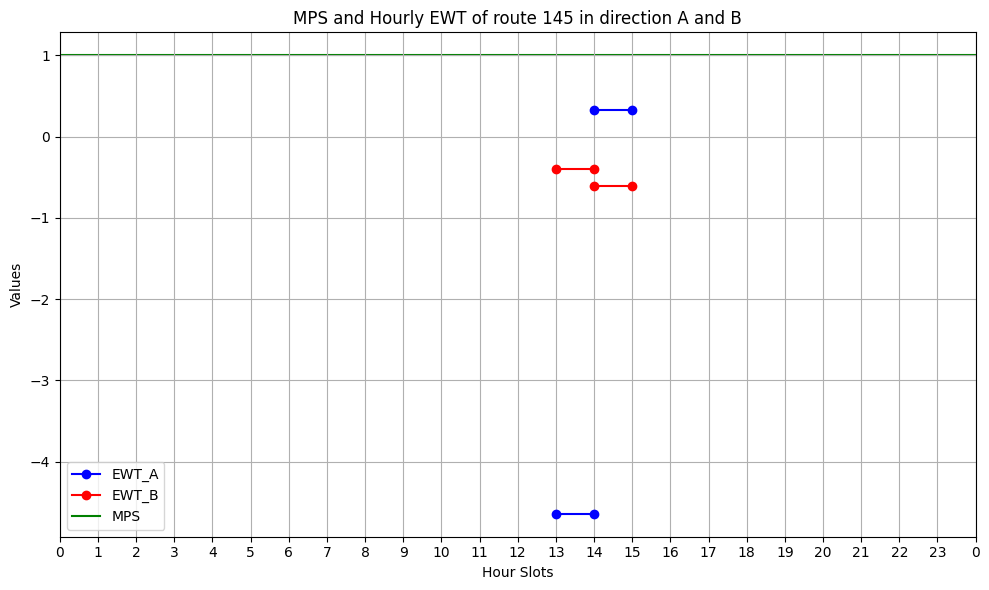



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 24.0   48.0   576.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 24.0   48.0   576.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

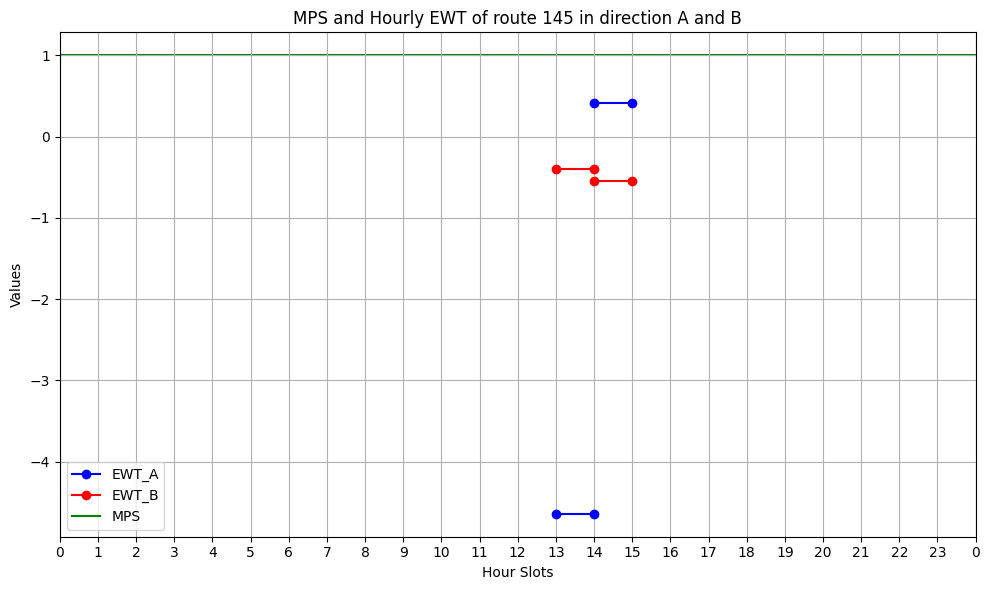



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 24.0   48.0   576.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 24.0   48.0   576.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

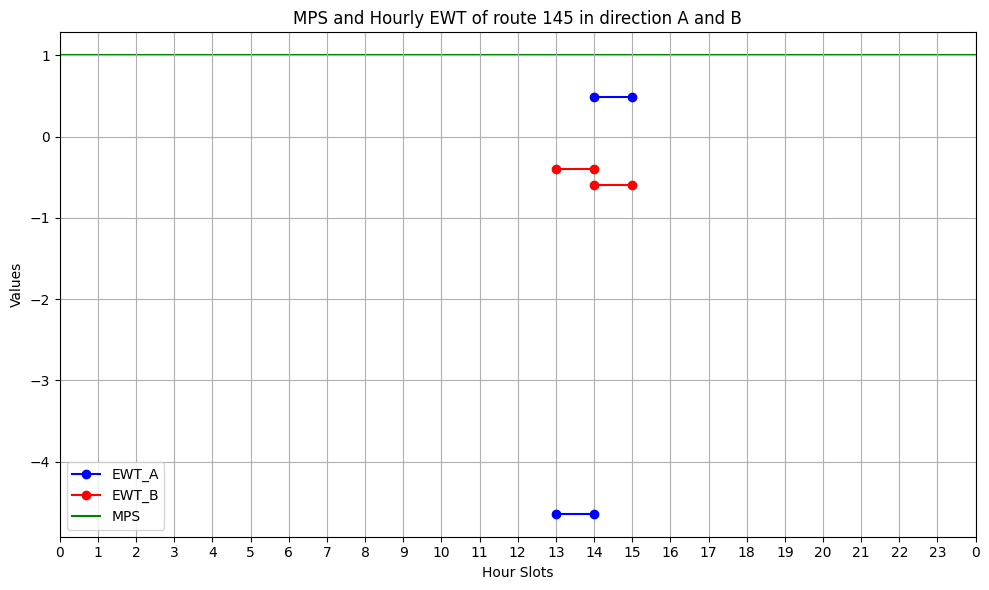



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 24.0   48.0   576.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 24.0   48.0   576.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

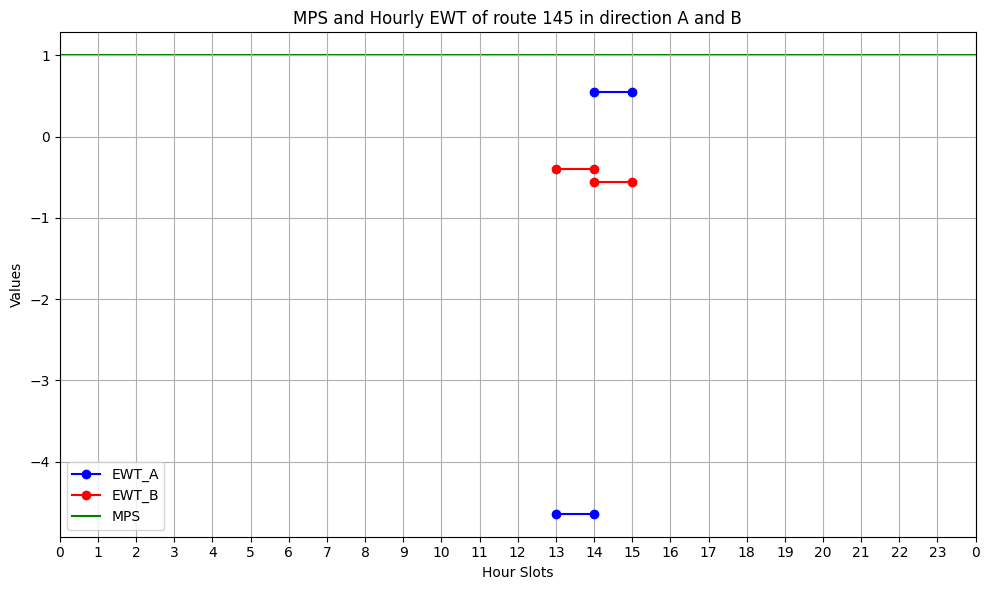



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 24.0   48.0   576.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YY66PHA 490005922N  outbound    2024-07-17 14:06:10   1900-01-01 14:06:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 24.0   48.0   576.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

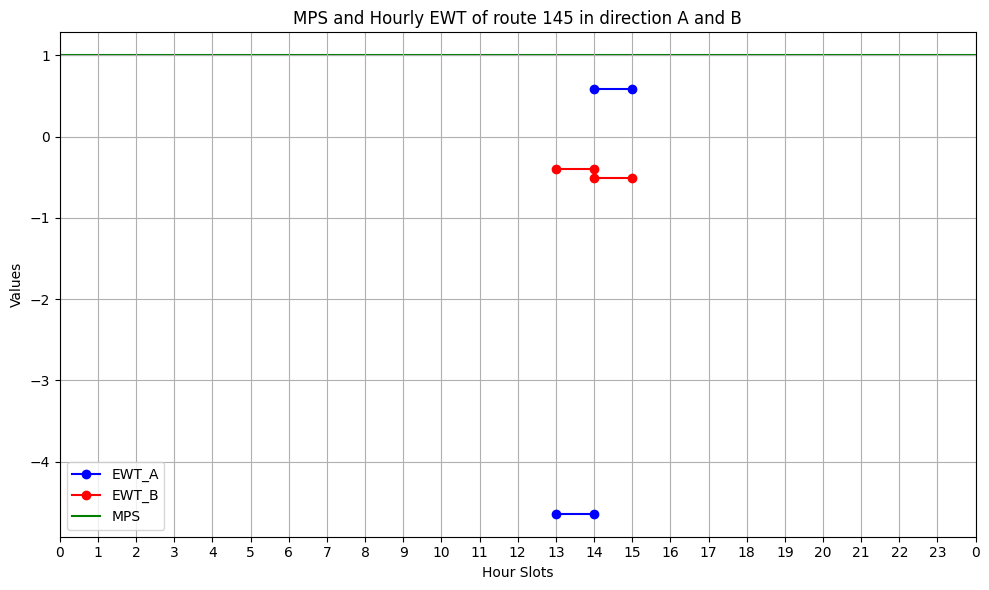



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Number of buses observed in the current hour: 1

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    1.0
2                                      SWT (minutes)    5.0
3                                                MPS    1.0
4                                       Total_Gap_Sq    0.0
5                         

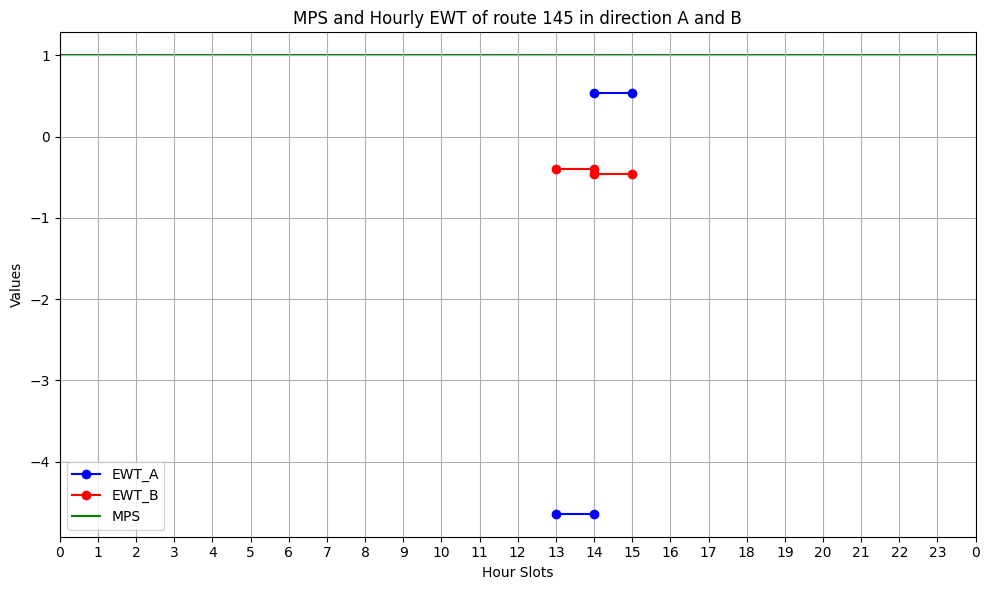



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Number of buses observed in the current hour: 1

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    1.0
2                                      SWT (minutes)    5.0
3                                                MPS    1.0
4                                       Total_Gap_Sq    0.0
5                         

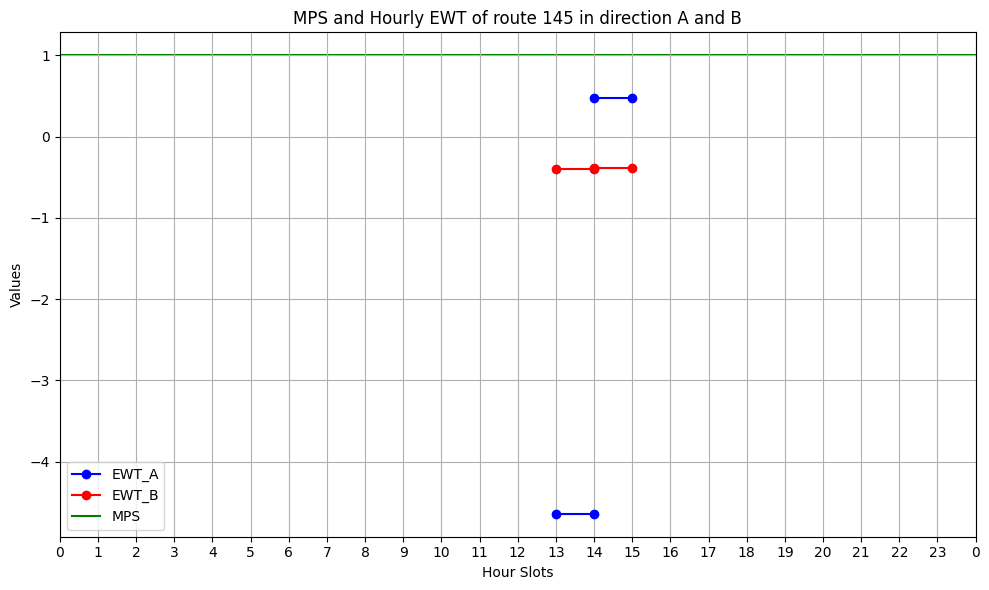



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Number of buses observed in the current hour: 1

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    1.0
2                                      SWT (minutes)    5.0
3                                                MPS    1.0
4                                       Total_Gap_Sq    0.0
5                         

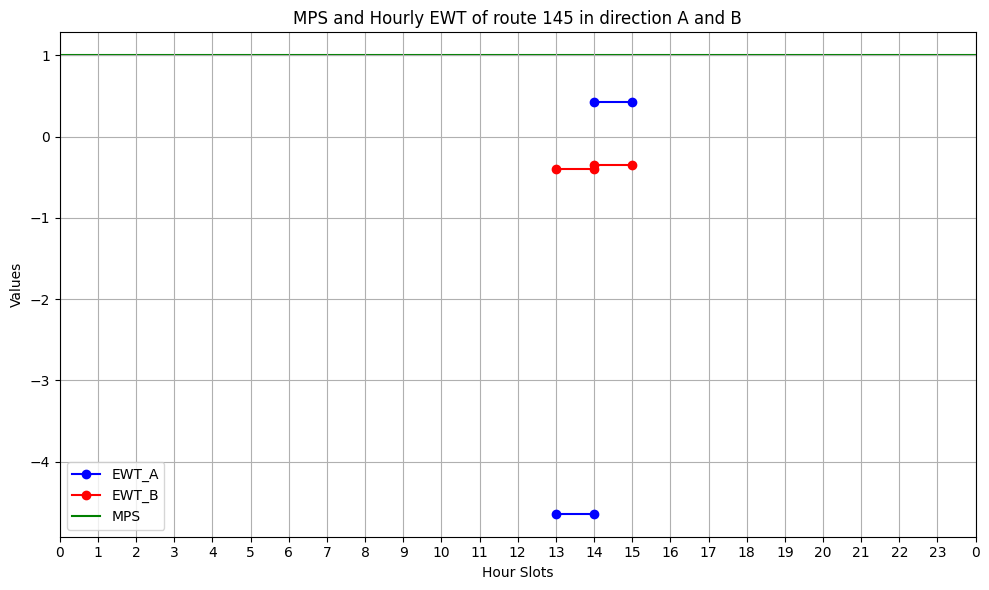



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Number of buses observed in the current hour: 1

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    1.0
2                                      SWT (minutes)    5.0
3                                                MPS    1.0
4                                       Total_Gap_Sq    0.0
5                         

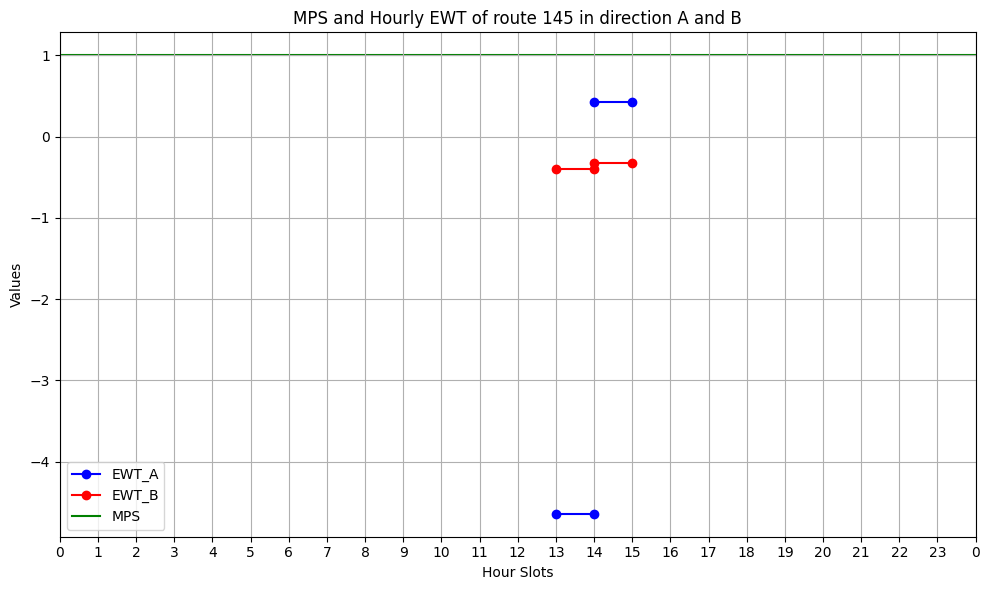



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Number of buses observed in the current hour: 1

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    1.0
2                                      SWT (minutes)    5.0
3                                                MPS    1.0
4                                       Total_Gap_Sq    0.0
5                         

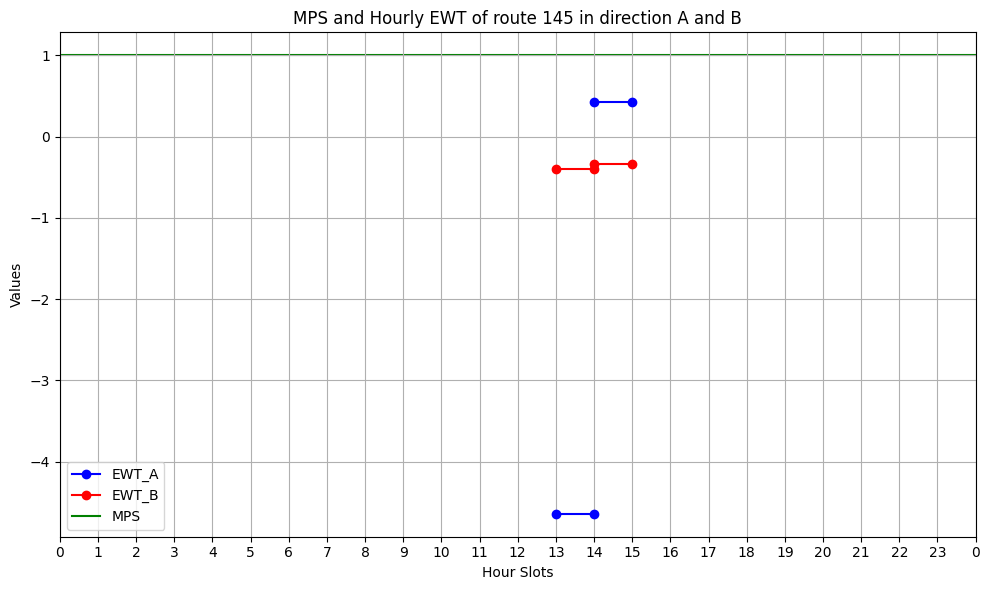



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00  0.0    0.0     0.0

Number of buses observed in the current hour: 1

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    1.0
2                                      SWT (minutes)    5.0
3                                                MPS    1.0
4                                       Total_Gap_Sq    0.0
5                         

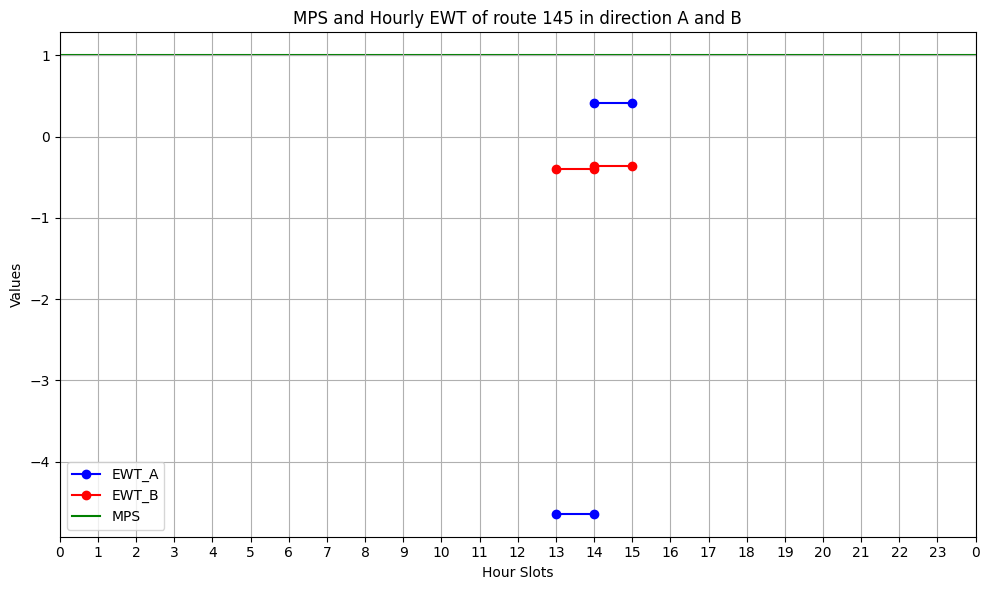



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

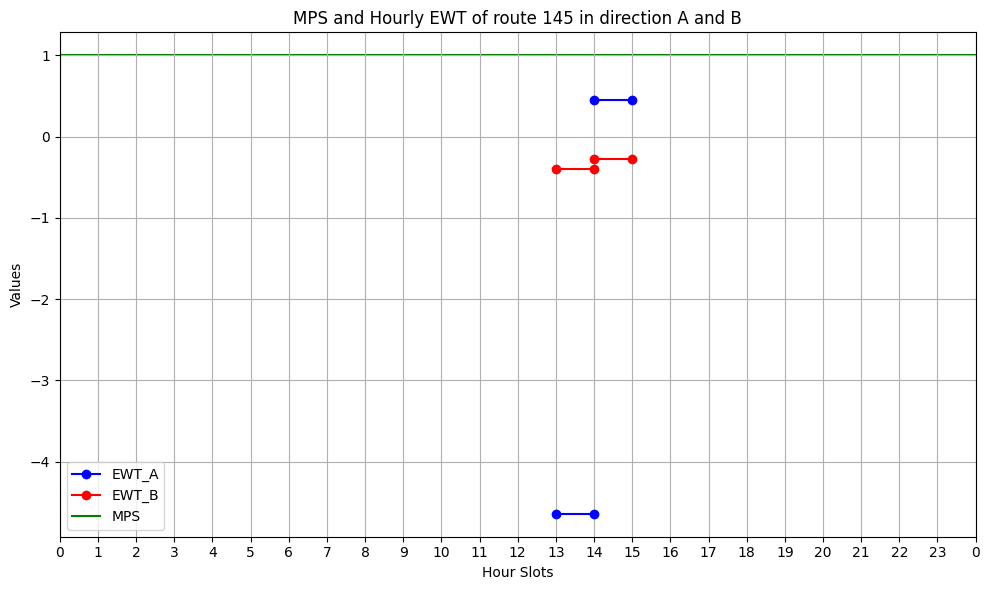



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

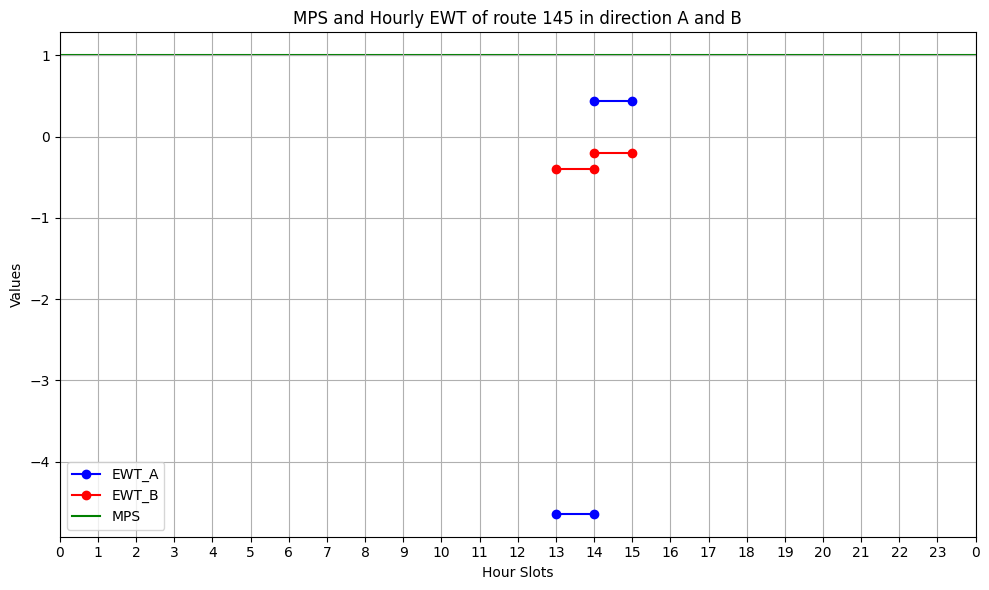



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

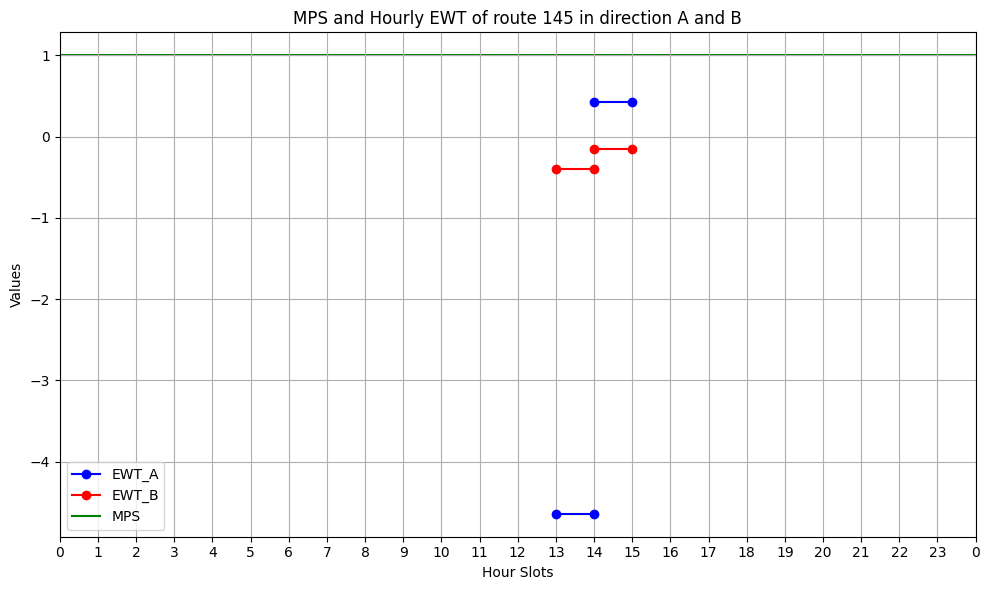



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

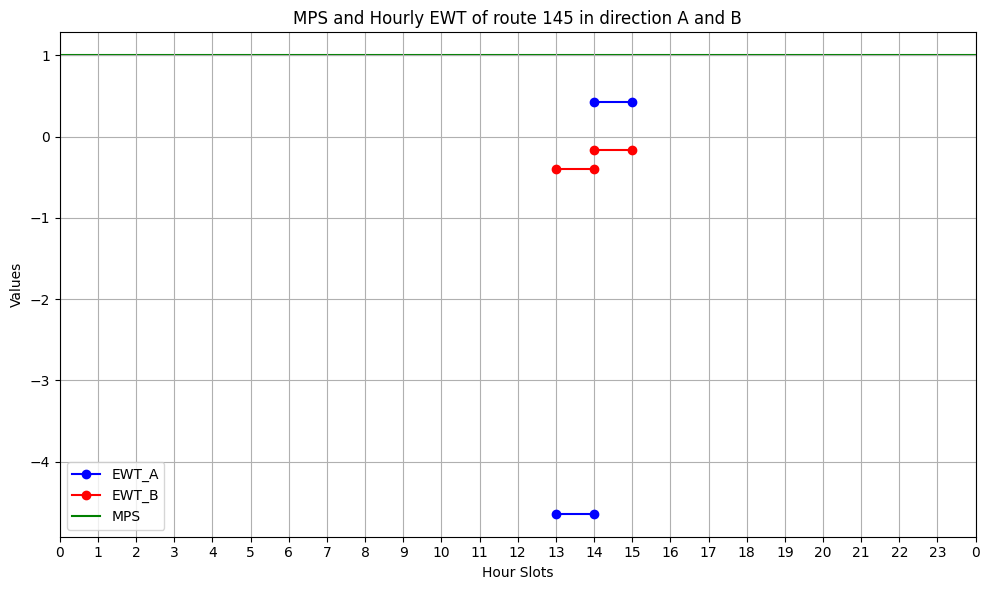



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

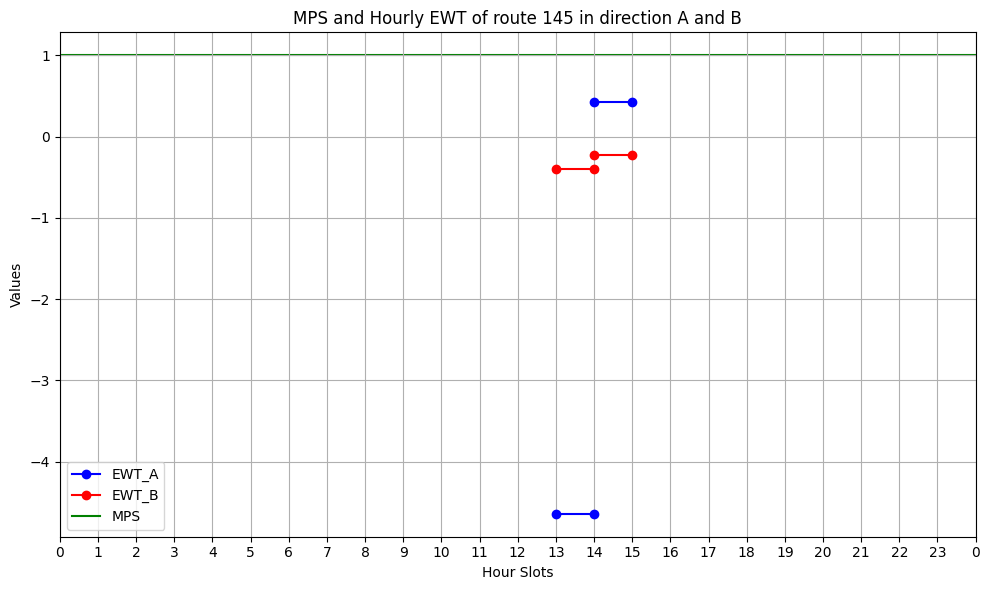



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

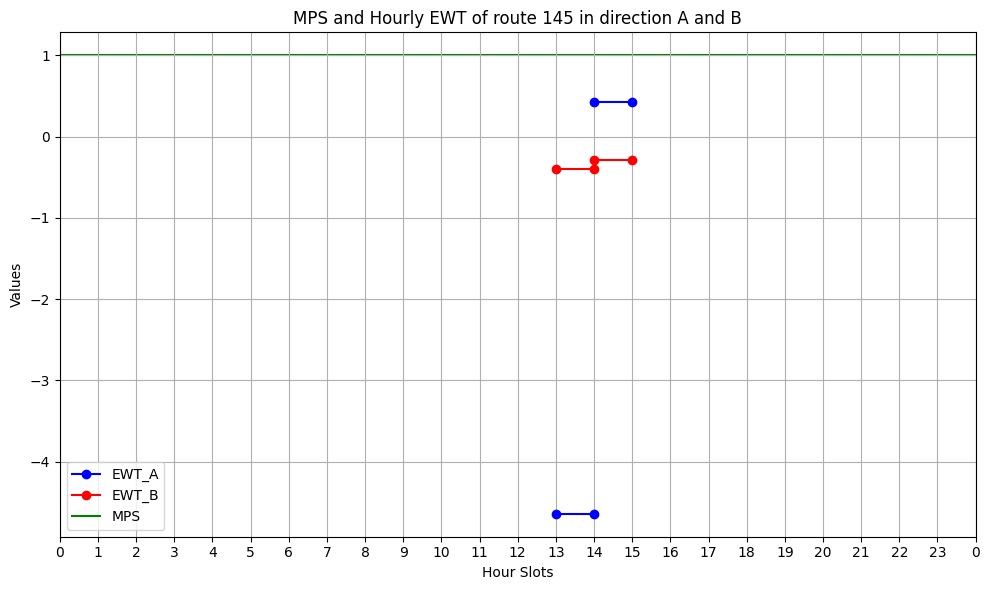



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

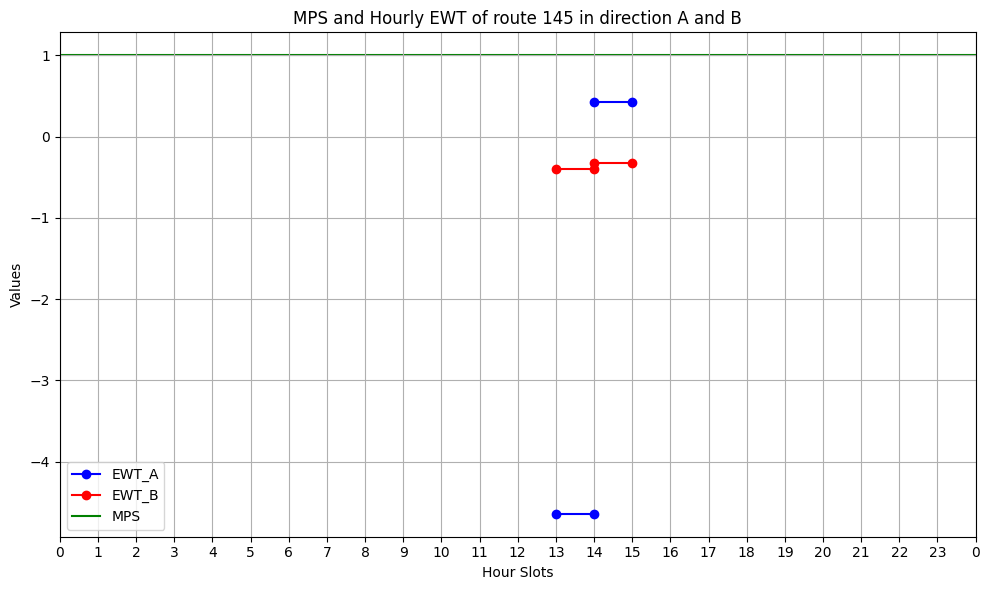



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

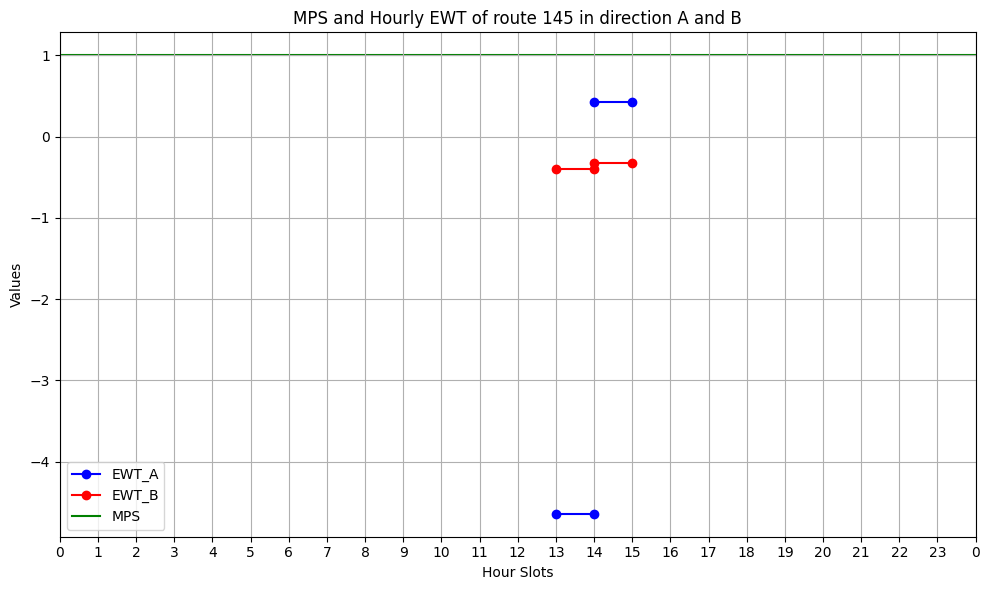



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

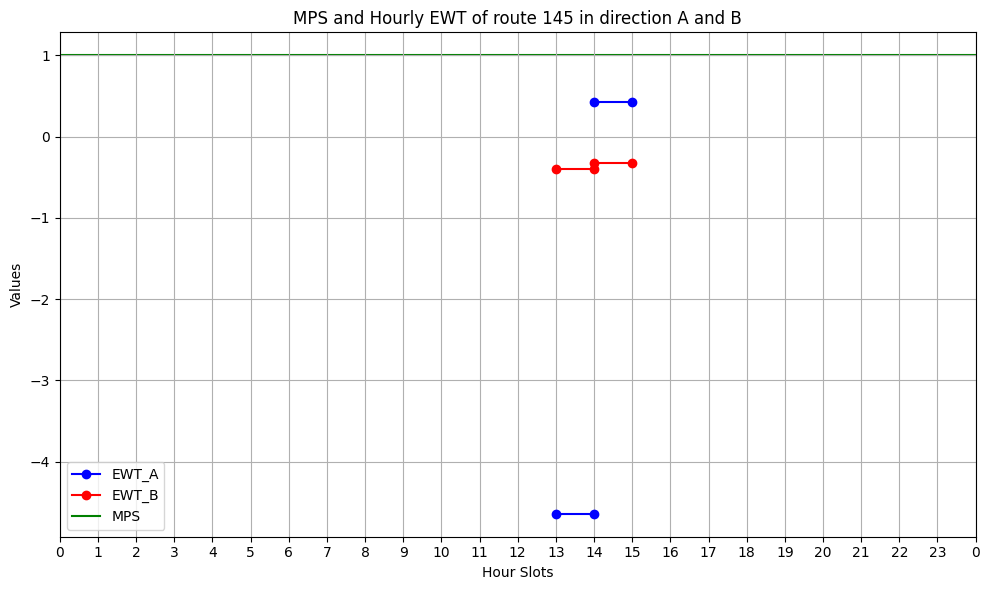



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

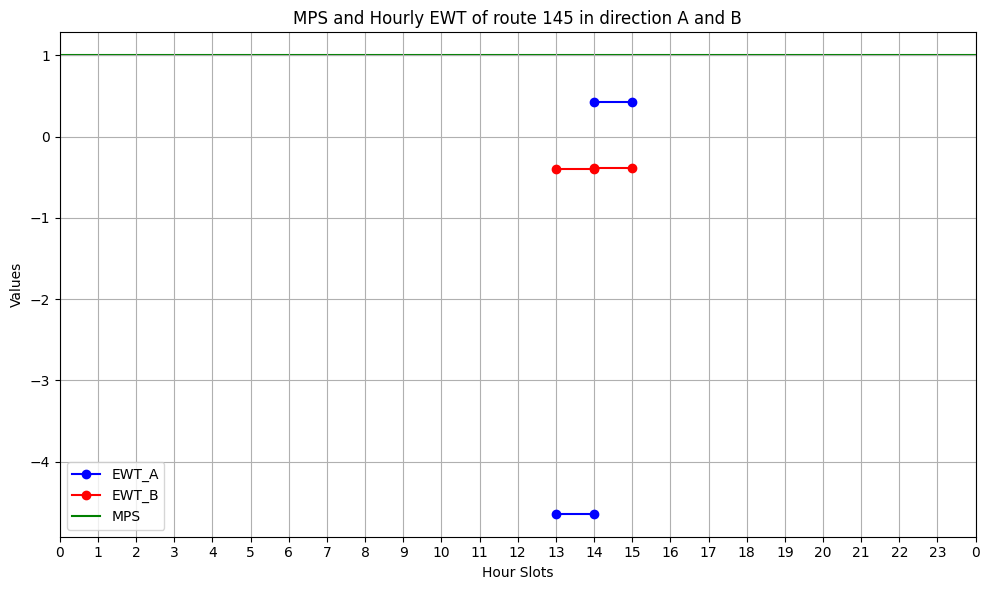



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

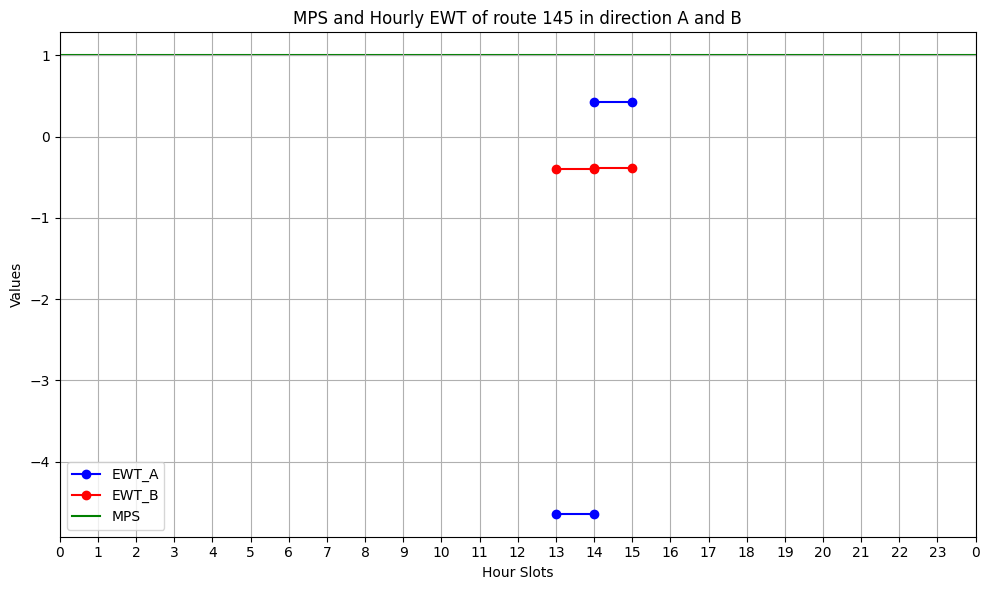



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

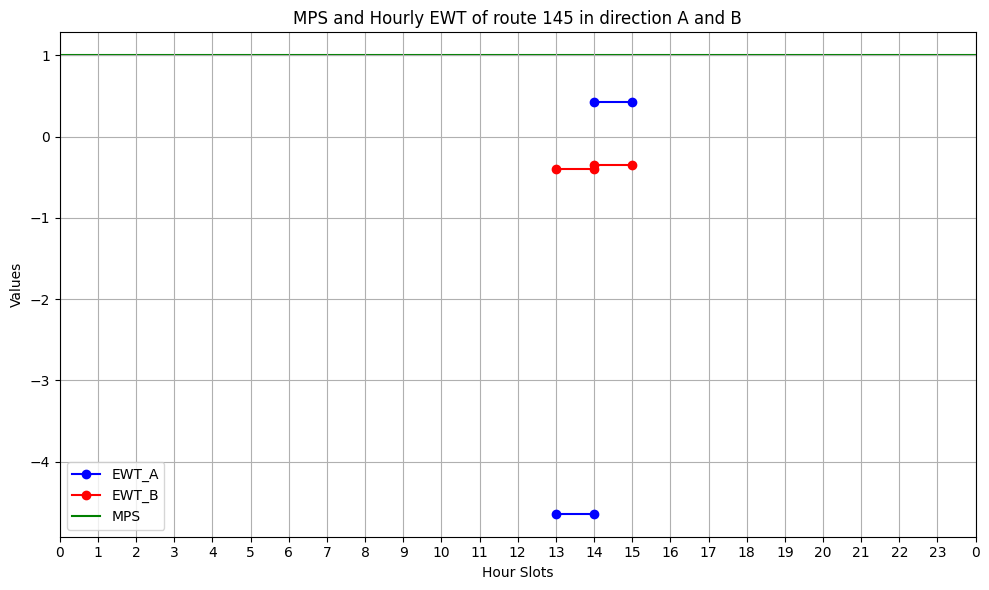



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

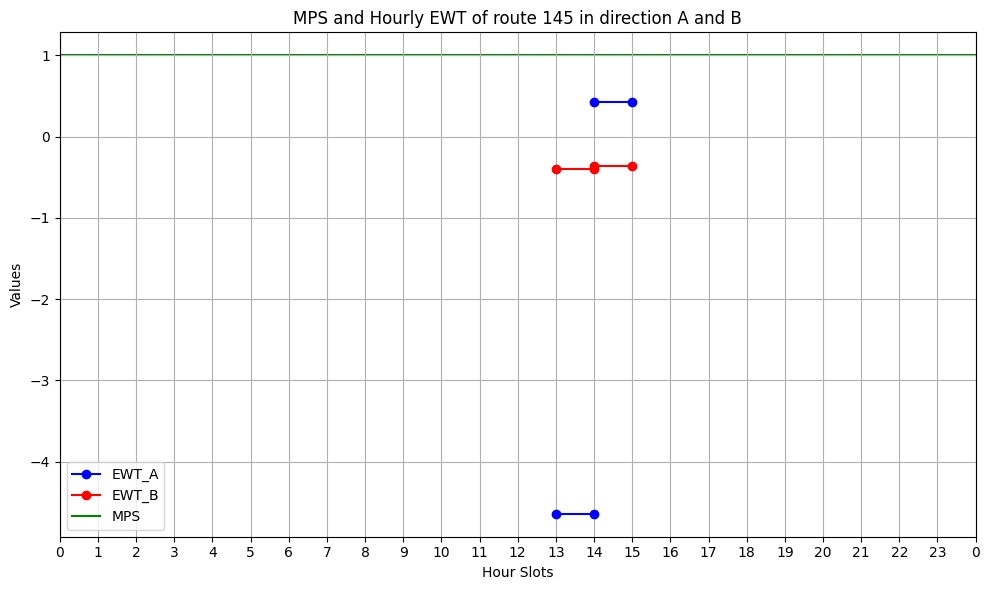



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

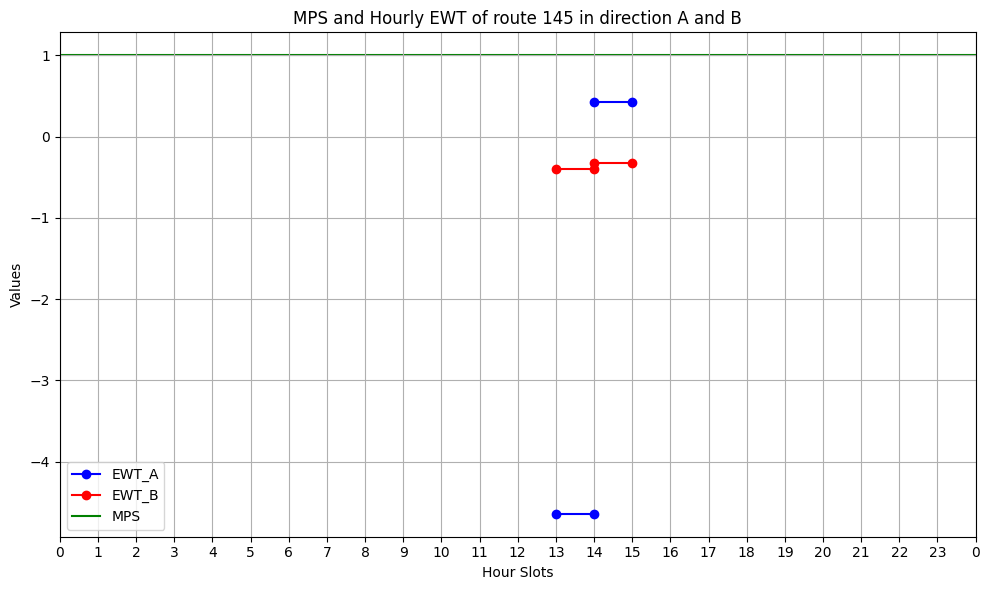



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

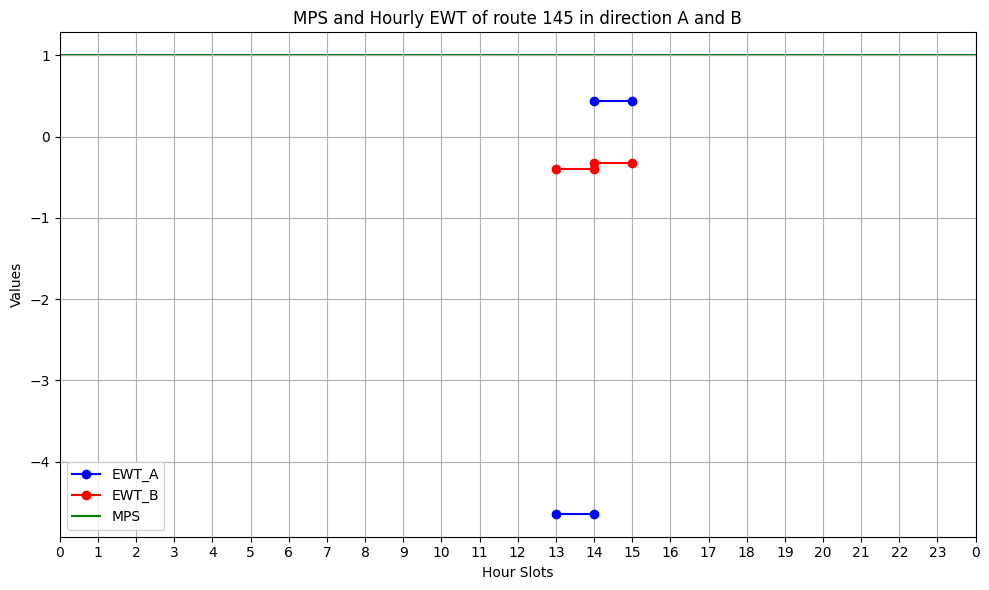



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:30:59   1900-01-01 14:30:00 12.0   24.0   144.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

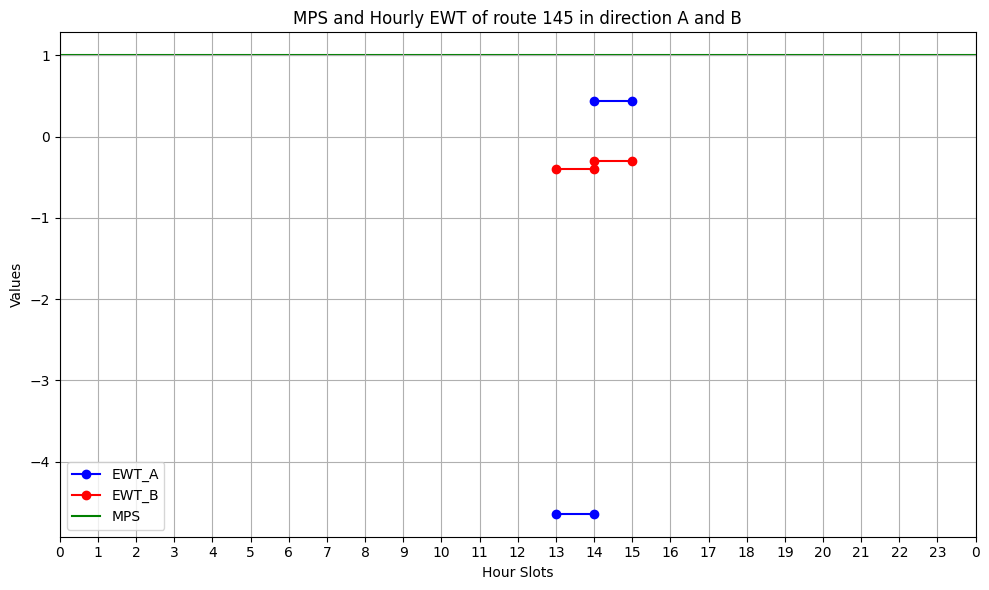



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00 16.0   32.0   256.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00 16.0   32.0   256.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

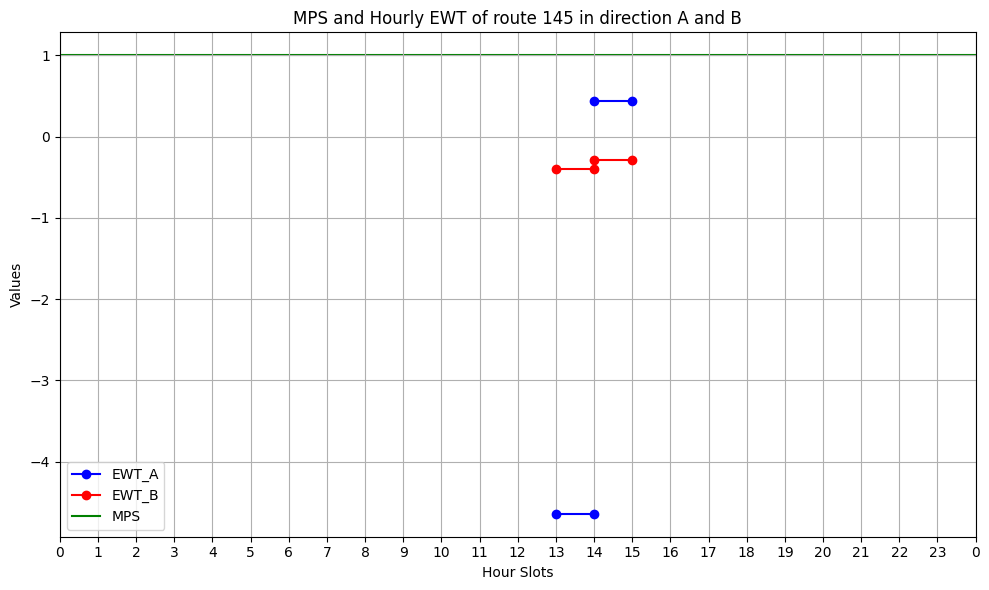



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00 16.0   32.0   256.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00 16.0   32.0   256.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

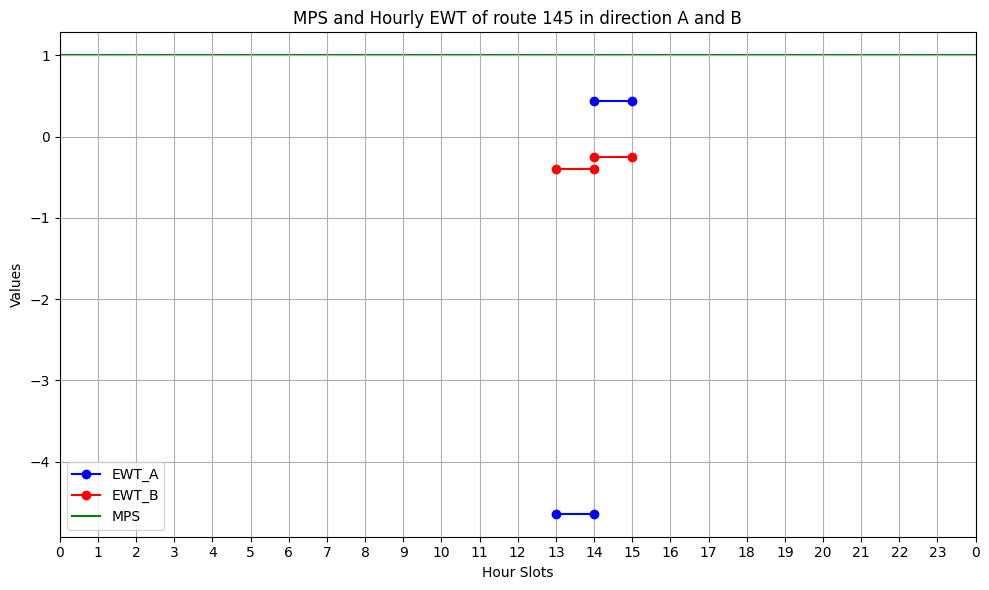



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00 16.0   32.0   256.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490005922N  outbound    2024-07-17 14:18:10   1900-01-01 14:18:00  0.0    0.0     0.0
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00 16.0   32.0   256.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

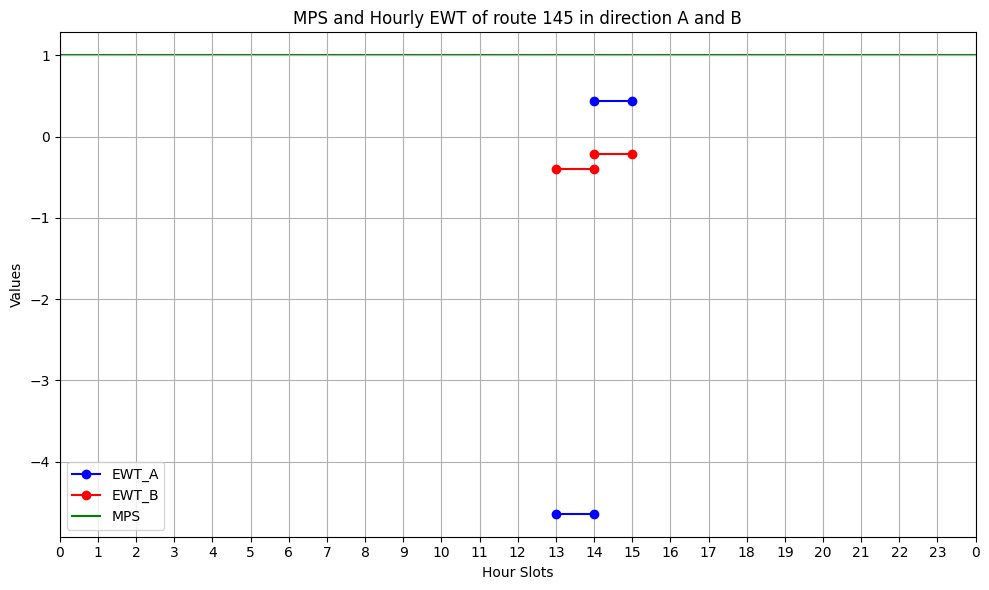



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

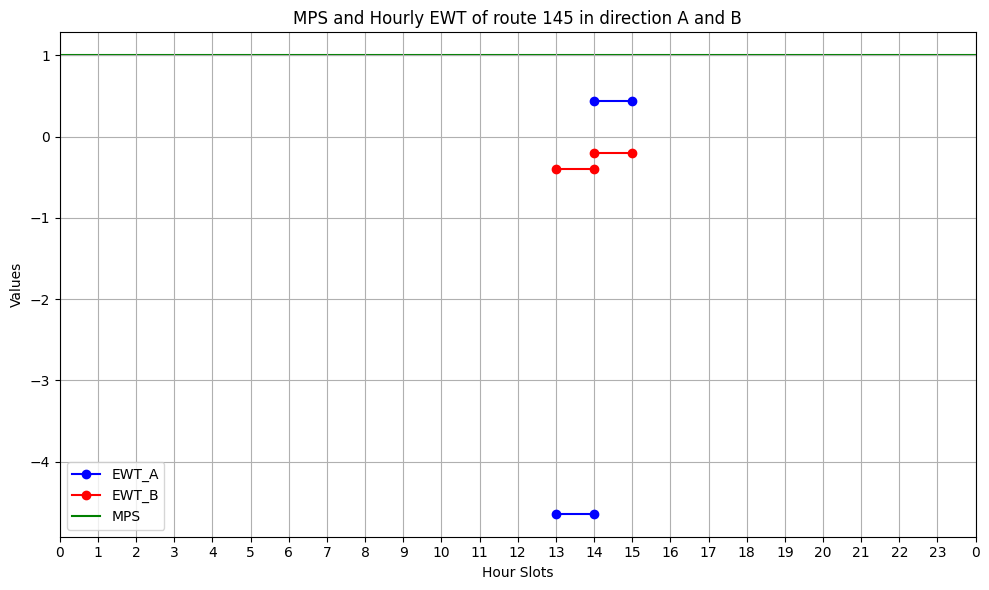



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

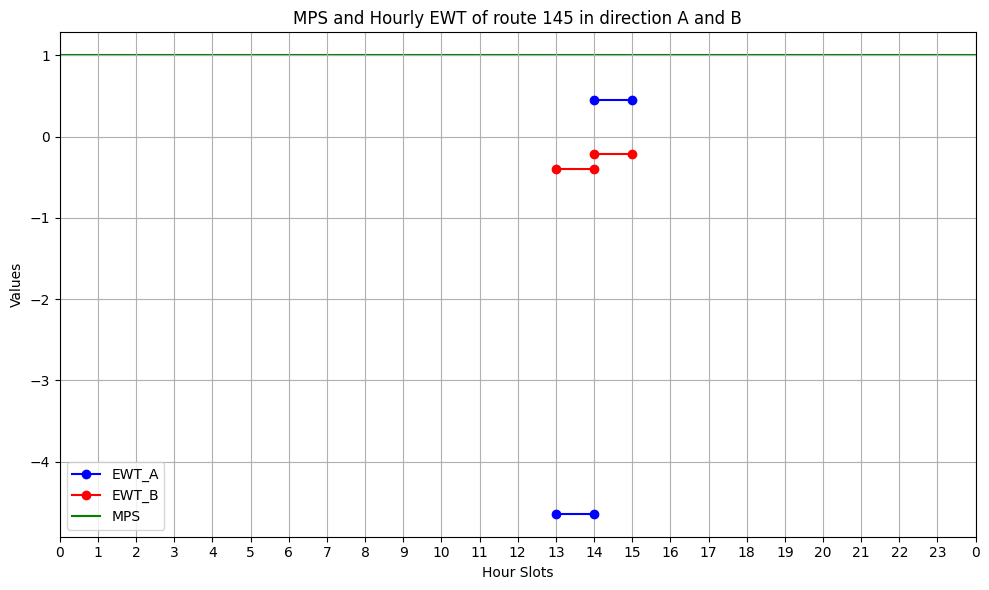



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

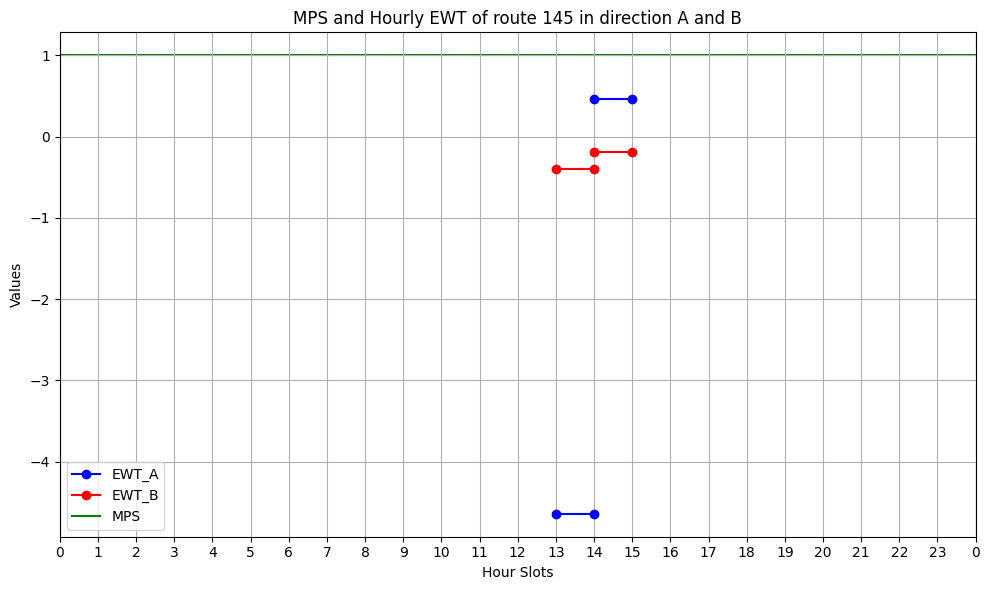



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

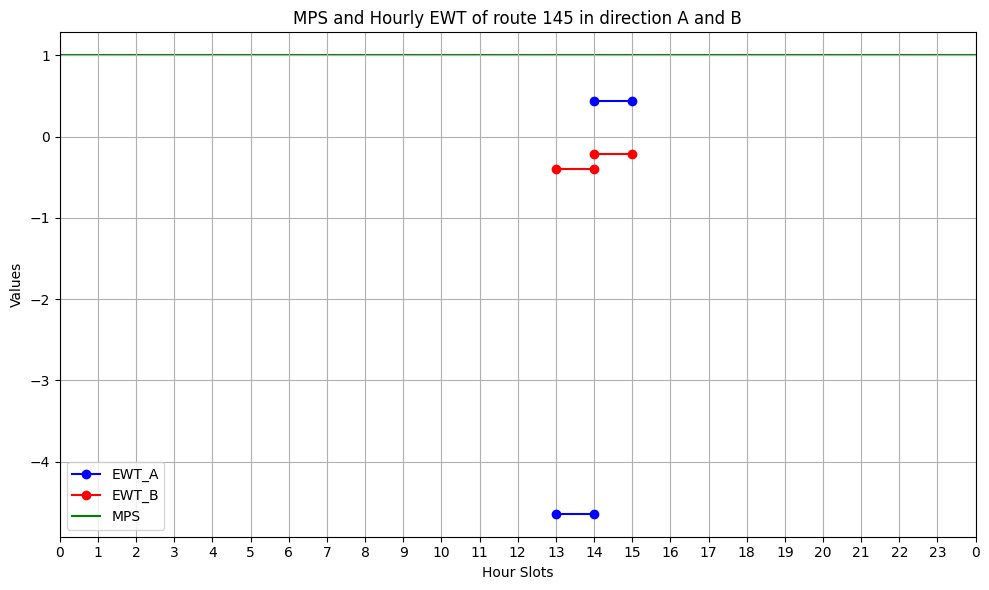



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

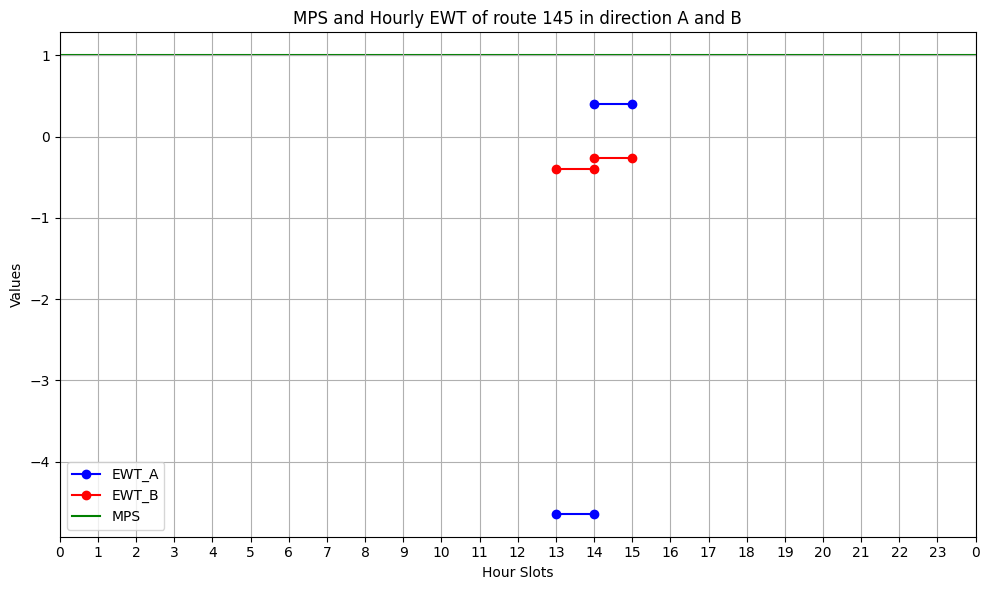



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    LX12DFP 490005922N  outbound    2024-07-17 14:34:04   1900-01-01 14:34:00  0.0    0.0     0.0
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00 14.0   28.0   196.0

Number of buses observed in the current hour: 2

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    2.0
2 

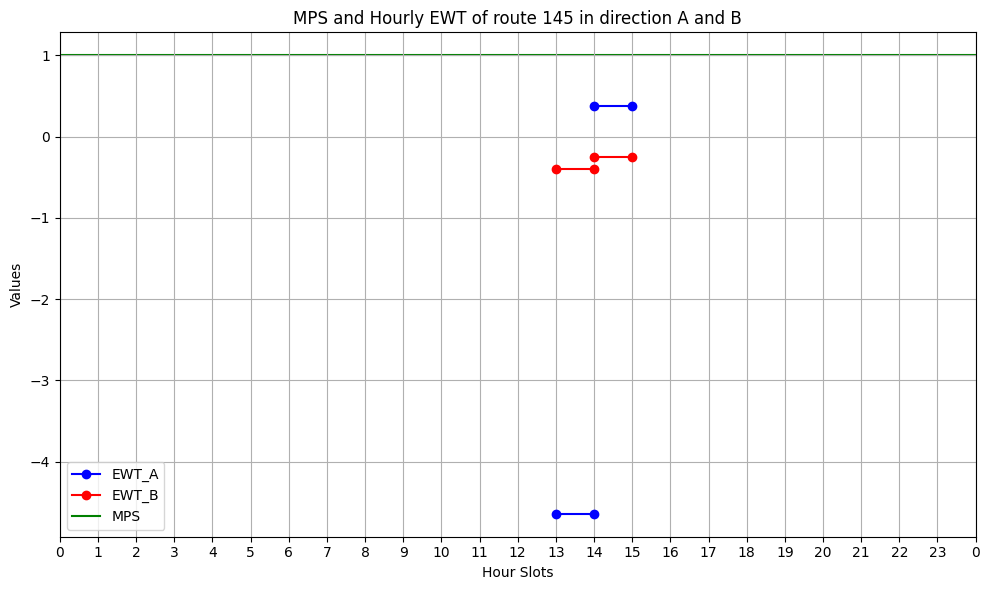



Waiting to fetch updated data...



Arrival Predictions for stop point 490005922N (Dagenham Asda):
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00  0.0    0.0     0.0

Cumulative DataFrame:
Line Vehicle ID Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    YX16OHP 490005922N  outbound    2024-07-17 14:48:10   1900-01-01 14:48:00  0.0    0.0     0.0

Number of buses observed in the current hour: 1

Summary Metrics for 490005922N:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number of buses observed    1.0
2                                      SWT (minutes)    5.0
3                                                MPS    1.0
4                                       Total_Gap_Sq    0.0
5                         

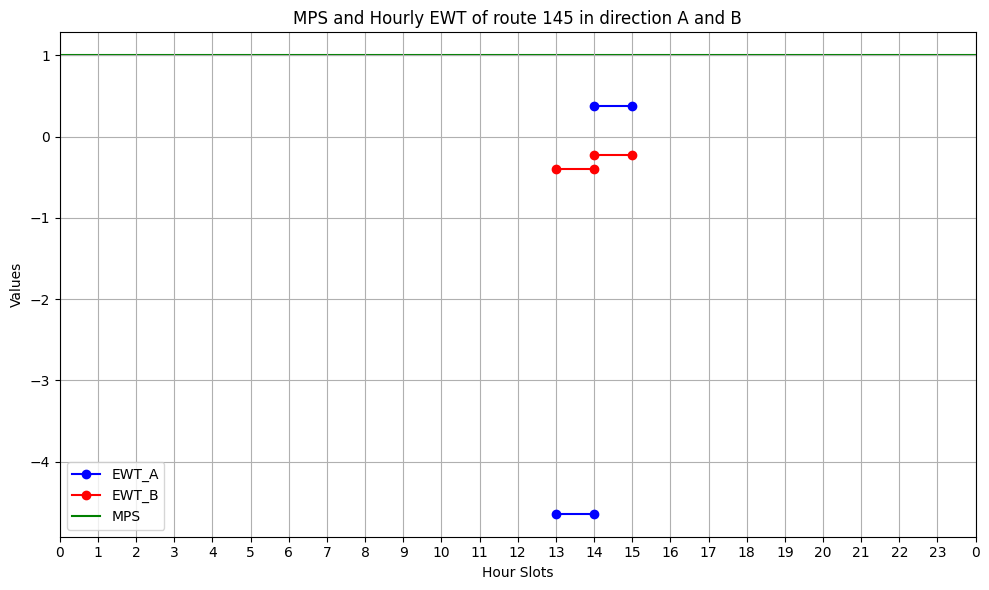



Waiting to fetch updated data...



Arrival Predictions for stop point 490003565E2 (Ballards Road / Princess Parade):
Line Vehicle ID  Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490003565E2  outbound    2024-07-17 14:23:50   1900-01-01 14:23:00  0.0    0.0     0.0
 145    LX12DFP 490003565E2  outbound    2024-07-17 14:39:47   1900-01-01 14:39:00 16.0   32.0   256.0

Cumulative DataFrame:
Line Vehicle ID  Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490003565E2  outbound    2024-07-17 14:23:50   1900-01-01 14:23:00  0.0    0.0     0.0
 145    LX12DFP 490003565E2  outbound    2024-07-17 14:39:47   1900-01-01 14:39:00 16.0   32.0   256.0

Number of buses observed in the current hour: 2

Summary Metrics for 490003565E2:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number o

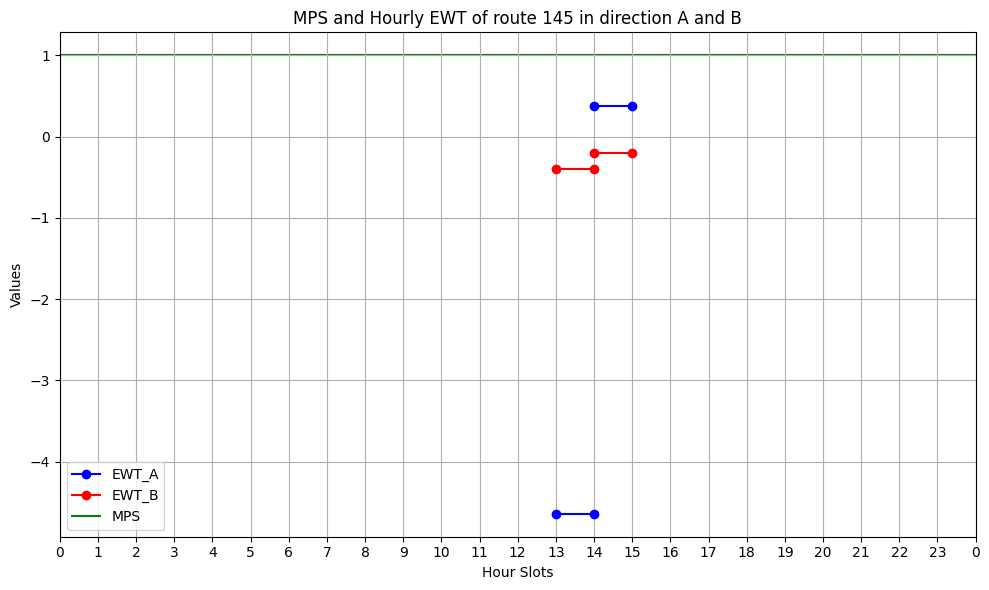



Waiting to fetch updated data...



Arrival Predictions for stop point 490003565E2 (Ballards Road / Princess Parade):
Line Vehicle ID  Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490003565E2  outbound    2024-07-17 14:24:27   1900-01-01 14:24:00  0.0    0.0     0.0
 145    LX12DFP 490003565E2  outbound    2024-07-17 14:39:47   1900-01-01 14:39:00 15.0   30.0   225.0

Cumulative DataFrame:
Line Vehicle ID  Stop Point Direction Expected Arrival (BST) Expected Arrival (HM)  Gap  2_Gap  Gap_Sq
 145    SN63JWK 490003565E2  outbound    2024-07-17 14:24:27   1900-01-01 14:24:00  0.0    0.0     0.0
 145    LX12DFP 490003565E2  outbound    2024-07-17 14:39:47   1900-01-01 14:39:00 15.0   30.0   225.0

Number of buses observed in the current hour: 2

Summary Metrics for 490003565E2:
                                              Metric  Value
0          Number of buses scheduled per hour (nbph)    6.0
1                           Number o

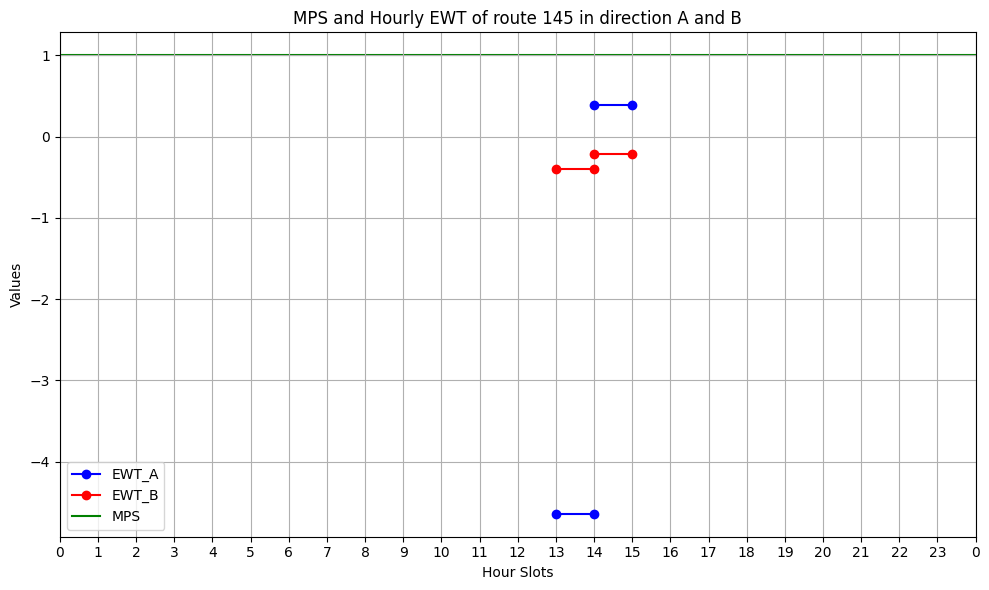



Waiting to fetch updated data...




Execution interrupted. Exiting the loop.



In [ ]:
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from datetime import datetime, timedelta
import pytz
import time
from IPython.display import clear_output
import numpy as np

cumulative_df = pd.DataFrame()
# Initialize empty DataFrame for AWT data
awt_data = pd.DataFrame(columns=['Route_Dir_QSI_No','Stop Point ID', 'AWT','No_Buses_Obs','EWT'])


# Function to normalize stop names
def normalize_stop_name(name):
    return ' '.join(name.lower().split())

# Function to fetch data from the API
def fetch_data(url):
    response = requests.get(url)
    return response.json()

# Function to extract schedule names
def extract_schedule_names(data, schedule_names_dict={}):
    if isinstance(data, dict):
        if data.get('$type') == "Tfl.Api.Presentation.Entities.Schedule, Tfl.Api.Presentation.Entities" and 'knownJourneys' in data:
            if 'name' in data:
                schedule_names_dict[data['name']] = data['knownJourneys']
        for key, value in data.items():
            extract_schedule_names(value, schedule_names_dict)
    elif isinstance(data, list):
        for item in data:
            extract_schedule_names(item, schedule_names_dict)
    return schedule_names_dict

# Function to categorize journeys into hourly slots
def categorize_into_slots(timetable):
    slots = [[] for _ in range(24)]
    for journey in timetable:
        hour = int(journey['hour'])  # Convert hour to integer
        slot = hour % 24  # Map hour to the correct slot
        slots[slot].append(journey)
    return slots

# Function to fetch the current day of the week
def get_day_of_week():
    bst = pytz.timezone('Europe/London')
    now = datetime.now(bst)
    return now.strftime('%A')  # %A gives full weekday name (e.g., 'Monday')

# Function to retrieve stop names from TfL API and match with Route_Dir_QSI_No
def find_route_details(lineID, df):
    # Ensure the 'Route_Dir_QSI_No' column exists
    if 'Route_Dir_QSI_No' not in df.columns:
        print("The 'Route_Dir_QSI_No' column is not present in the provided file.")
        return

    # Convert the lineID to uppercase to ensure case-insensitivity
    lineID = lineID.upper()

    # Convert the 'Route_Dir_QSI_No' column to uppercase for comparison
    df['Route_Dir_QSI_No'] = df['Route_Dir_QSI_No'].str.upper()

    # Normalize the stop names in the DataFrame
    df['STOP_NAME'] = df['STOP_NAME'].apply(normalize_stop_name)

    # Filter the DataFrame based on the lineID
    pattern_A = f"^{lineID}_A\\d+$"  # Regular expression for D7_A**
    pattern_B = f"^{lineID}_B\\d+$"  # Regular expression for D7_B**

    # Filter rows where the 'Route_Dir_QSI_No' column matches the pattern
    filtered_df_A = df[df['Route_Dir_QSI_No'].str.match(pattern_A, na=False)]
    filtered_df_B = df[df['Route_Dir_QSI_No'].str.match(pattern_B, na=False)]

    # Function to fetch and process route sequence data from TfL API
    def fetch_and_process_route_data(route_type, pattern, filtered_df):
        api_url = f"https://api.tfl.gov.uk/Line/{lineID}/Route/Sequence/{route_type}"
        response = requests.get(api_url)

        results_list = []

        if response.status_code == 200:
            route_data = response.json()

            # Iterate through each stop in the route data
            for stop in route_data['stopPointSequences'][0]['stopPoint']:
                stop_name_api = normalize_stop_name(stop['name'])
                stop_id = stop['id']

                # Check if the stop_name_api exists in the filtered DataFrame for the correct direction
                matched_row = filtered_df[(filtered_df['STOP_NAME'] == stop_name_api) &
                                          (filtered_df['Route_Dir_QSI_No'].str.match(pattern))]

                if not matched_row.empty:
                    route_dir_qsi_no = matched_row.iloc[0]['Route_Dir_QSI_No']
                    results_list.append({
                        'Route_Dir_QSI_No': route_dir_qsi_no,
                        'STOP_Name': stop['name'],
                        'ID': stop_id
                    })
                else:
                    # If exact match not found, try partial matching based on words before and after '/'
                    api_stop_name_parts = stop_name_api.split('/')
                    for index, row in filtered_df.iterrows():
                        df_stop_name_parts = row['STOP_NAME'].split('/')
                        for api_part in api_stop_name_parts:
                            for df_part in df_stop_name_parts:
                                if SequenceMatcher(None, df_part.strip(), api_part.strip()).ratio() > 0.8:
                                    matched_row = pd.DataFrame([row])
                                    break
                            if not matched_row.empty:
                                break
                        if not matched_row.empty:
                            break

                    if not matched_row.empty:
                        route_dir_qsi_no = matched_row.iloc[0]['Route_Dir_QSI_No']
                        results_list.append({
                            'Route_Dir_QSI_No': route_dir_qsi_no,
                            'STOP_Name': stop['name'],
                            'ID': stop_id
                        })
        else:
            print(f"Failed to fetch route sequence data from TfL API for {route_type} route. Status code: {response.status_code}")

        return results_list

    # Fetch and process outbound route data for _A**
    matched_results_A = fetch_and_process_route_data('outbound', pattern_A, filtered_df_A)

    # Fetch and process inbound route data for _B**
    matched_results_B = fetch_and_process_route_data('inbound', pattern_B, filtered_df_B)

    # Create DataFrames from the matched results for each direction
    matched_results_df_A = pd.DataFrame(matched_results_A)
    matched_results_df_B = pd.DataFrame(matched_results_B)

    # Function to remove partial matches if exact matches are found
    def remove_partial_matches(exact_df, matched_df):
        for index, row in exact_df.iterrows():
            exact_stop_name = row['STOP_NAME']
            route_dir_qsi_no = row['Route_Dir_QSI_No']
            # Find exact matches in matched_df
            exact_matches = matched_df[(matched_df['Route_Dir_QSI_No'] == route_dir_qsi_no) &
                                       (matched_df['STOP_Name'].apply(normalize_stop_name) == exact_stop_name)]
            if not exact_matches.empty:
                # Remove partial matches
                matched_df = matched_df[~((matched_df['Route_Dir_QSI_No'] == route_dir_qsi_no) &
                                          (matched_df['STOP_Name'].apply(normalize_stop_name) != exact_stop_name))]
        return matched_df

    # Remove partial matches for direction A
    matched_results_df_A = remove_partial_matches(filtered_df_A, matched_results_df_A)

    # Remove partial matches for direction B
    matched_results_df_B = remove_partial_matches(filtered_df_B, matched_results_df_B)

    # Remove duplicate stop names with the same Route_Dir_QSI_No and different IDs
    matched_results_df_A = matched_results_df_A.drop_duplicates(subset=['Route_Dir_QSI_No', 'STOP_Name'], keep='first')
    matched_results_df_B = matched_results_df_B.drop_duplicates(subset=['Route_Dir_QSI_No', 'STOP_Name'], keep='first')

    # Print the matched results for direction A
    print(f"\n\n\033[1m\033[4mQSI stop points for direction {lineID}_A\033[0m\n")
    matched_results_df_A = matched_results_df_A[matched_results_df_A['Route_Dir_QSI_No'].str.match(pattern_A)]
    print(matched_results_df_A[['Route_Dir_QSI_No', 'STOP_Name', 'ID']])

    # Print the matched results for direction B
    print(f"\n\n\033[1m\033[4mQSI stop points for direction {lineID}_B\033[0m\n")
    matched_results_df_B = matched_results_df_B[matched_results_df_B['Route_Dir_QSI_No'].str.match(pattern_B)]
    print(matched_results_df_B[['Route_Dir_QSI_No', 'STOP_Name', 'ID']])

    # Concatenate the matched results DataFrames for directions A and B
    combined_df = pd.concat([matched_results_df_A, matched_results_df_B], ignore_index=True)

    # DataFrames to store SWT data
    swt_data = {
        'Route_Dir_QSI_No': [],
        'ID': [],
        'SWT': [],
        'No_Buses_Sch': [],
        'SWT_hr1': [],
        'No_Buses_Sch_hr1': [],
        'SWT_hr2': [],
        'No_Buses_Sch_hr2': []
    }

    # Fetch timetable for each stop point ID and calculate SWT
    bst = pytz.timezone('Europe/London')
    current_hour = datetime.now(bst).hour
    day_of_week = get_day_of_week()

    # Store selected schedule name to ensure it's printed only once
    selected_schedule_name = None
    printed_schedule_name = False

    # Track printed timetable stop IDs
    printed_timetable_stop_ids = []

    while True:
        # Clear previous awt_data DataFrame
        awt_data = pd.DataFrame(columns=['Route_Dir_QSI_No','Stop Point ID','AWT','No_Buses_Obs','EWT'])

        # Update current time and hour
        now = datetime.now(bst)
        current_hour = now.hour
        day_of_week = get_day_of_week()

        # Clear previous SWT data
        swt_data = {
            'Route_Dir_QSI_No': [],
            'ID': [],
            'SWT': [],
            'No_Buses_Sch': [],
            'SWT_hr1': [],
            'No_Buses_Sch_hr1': [],
            'SWT_hr2': [],
            'No_Buses_Sch_hr2': []
        }

        for index, row in combined_df.iterrows():
            stop_point_id = row['ID']
            route_dir_qsi_no = row['Route_Dir_QSI_No']

            if f"{lineID}_A" in route_dir_qsi_no:
                direction = 'outbound'
            elif f"{lineID}_B" in route_dir_qsi_no:
                direction = 'inbound'
            else:
                print(f"Invalid route direction for Route_Dir_QSI_No: {route_dir_qsi_no}")
                continue

            url = f'https://api.tfl.gov.uk/Line/{lineID}/Timetable/{stop_point_id}?direction={direction}'
            data = fetch_data(url)

            schedule_names_dict = extract_schedule_names(data)

            if not selected_schedule_name:
                if day_of_week.lower() in ['monday', 'tuesday', 'wednesday', 'thursday']:
                    preferred_schedule_names = ['Mon-Fri Schooldays', 'Monday to Thursday', 'Monday to Friday']
                elif day_of_week.lower() == 'friday':
                    preferred_schedule_names = ['Mon-Fri Schooldays', 'Monday to Friday', 'Friday']
                elif day_of_week.lower() == 'saturday':
                    preferred_schedule_names = ['Saturday']
                elif day_of_week.lower() == 'sunday':
                    preferred_schedule_names = ['Sunday']
                else:
                    preferred_schedule_names = [day_of_week]

                for preferred_name in preferred_schedule_names:
                    if preferred_name in schedule_names_dict:
                        selected_schedule_name = preferred_name
                        break

            if selected_schedule_name and not printed_schedule_name:
                print(f"\nToday is {day_of_week}. The selected Schedule name is {selected_schedule_name}.")
                printed_schedule_name = True

            if selected_schedule_name:
                timetable = schedule_names_dict[selected_schedule_name]
                slots = categorize_into_slots(timetable)

                # Calculate Scheduled Wait Time (SWT)
                total_buses_this_hour = len(slots[current_hour])
                scheduled_wait_time = 60 / (total_buses_this_hour * 2) if total_buses_this_hour > 0 else float('inf')
                next_hour = (current_hour + 1) % 24  # Wrap around using modulo operator
                total_buses_hr1 = len(slots[next_hour])
                scheduled_wait_time_hr1 = 60 / (total_buses_hr1 * 2) if total_buses_hr1 > 0 else float('inf')
                next_next_hour = (current_hour + 2) % 24  # Wrap around using modulo operator
                total_buses_hr2 = len(slots[next_next_hour])
                scheduled_wait_time_hr2 = 60 / (total_buses_hr2 * 2) if total_buses_hr2 > 0 else float('inf')

                # Store SWT data
                swt_data['Route_Dir_QSI_No'].append(route_dir_qsi_no)
                swt_data['ID'].append(stop_point_id)
                swt_data['SWT'].append(scheduled_wait_time)
                swt_data['No_Buses_Sch'].append(total_buses_this_hour)
                swt_data['SWT_hr1'].append(scheduled_wait_time_hr1)
                swt_data['No_Buses_Sch_hr1'].append(total_buses_hr1)
                swt_data['SWT_hr2'].append(scheduled_wait_time_hr2)
                swt_data['No_Buses_Sch_hr2'].append(total_buses_hr2)
                # Fetch arrival predictions based on SWT data for printed timetable stop IDs
                if stop_point_id in printed_timetable_stop_ids:
                    # Fetch arrival predictions
                    arrival_predictions_df, station_name = fetch_arrival_predictions(lineID, stop_point_id, direction)

                    if arrival_predictions_df is not None and not arrival_predictions_df.empty:
                        current_hour = datetime.now(pytz.timezone('Europe/London')).hour
                        next_hour = (current_hour + 1) % 24
                        cumulative_df = pd.DataFrame(columns=['Line', 'Vehicle ID', 'Stop Point', 'Direction','Expected Arrival (BST)', 'Expected Arrival (HM)','Gap', '2_Gap', 'Gap_Sq'])
                        for _, row in arrival_predictions_df.iterrows():
                            vehicle_id = row['Vehicle ID']
                            expected_hour = row['Expected Arrival (BST)'].hour
                            if (vehicle_id in cumulative_df['Vehicle ID'].values and
                                expected_hour in [current_hour, next_hour]):
                                cumulative_df.loc[(cumulative_df['Vehicle ID'] == vehicle_id) &
                                                  (cumulative_df['Expected Arrival (BST)'].dt.hour.isin([current_hour, next_hour])), :] = row.values
                            else:
                                cumulative_df = pd.concat([cumulative_df, row.to_frame().T]).reset_index(drop=True)

                        # Recalculate headway for cumulative_df
                        cumulative_df = cumulative_df.sort_values(by='Expected Arrival (BST)', ascending=True)
                        cumulative_df['Expected Arrival (BST)'] = pd.to_datetime(cumulative_df['Expected Arrival (BST)'])  # Ensure datetime format
                        cumulative_df['Expected Arrival (HM)'] = pd.to_datetime(cumulative_df['Expected Arrival (HM)'], format='%H:%M')

                        cumulative_df['Gap'] = cumulative_df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60

                        cumulative_df['2_Gap'] = (cumulative_df['Gap'] * 2).round(2)
                        cumulative_df['Gap_Sq'] = (cumulative_df['Gap'] * cumulative_df['Gap']).round(2)

                        # Calculate the number of buses observed in the current hour
                        num_buses_observed = cumulative_df[cumulative_df['Expected Arrival (BST)'].dt.hour == current_hour].shape[0]

                        print(f"\nArrival Predictions for stop point {stop_point_id} ({station_name}):")
                        print(arrival_predictions_df.to_string(index=False))
                        print("\nCumulative DataFrame:")
                        print(cumulative_df.to_string(index=False))
                        print(f"\nNumber of buses observed in the current hour: {num_buses_observed}")
                        # Calculating summary metrics
                        total_Gap_Sq = arrival_predictions_df['Gap_Sq'].sum()
                        total_2_Gap = arrival_predictions_df['2_Gap'].sum()
                        min_arrival = arrival_predictions_df['Expected Arrival (BST)'].min().replace(second=0, microsecond=0)
                        max_arrival = arrival_predictions_df['Expected Arrival (BST)'].max().replace(second=0, microsecond=0)
                        time_diff_minutes = (max_arrival - min_arrival).total_seconds() / 60
                        num_buses_observed = arrival_predictions_df['Vehicle ID'].nunique()

                        # Calculating AWT, SWT, and EWT
                        nbph = swt_data['No_Buses_Sch'][swt_data['ID'].index(stop_point_id)]
                        swt = swt_data['SWT'][swt_data['ID'].index(stop_point_id)]
                        awt = round(total_Gap_Sq / total_2_Gap, 2) if total_2_Gap > 0 else 0
                        ewt = round(awt - swt, 2)
                        MPS = filtered_data['MPS'].iloc[0]
                        ewt_var = round(ewt - MPS,2)
                        summary_df = pd.DataFrame({
                            'Metric': ['Number of buses scheduled per hour (nbph)', 'Number of buses observed', 'SWT (minutes)','MPS', 'Total_Gap_Sq', 'Total_2_Gap',
                                       'Time difference between 1st and last observed buses (minutes)', 'AWT (minutes)', 'EWT (minutes)', 'EWT Variance'],
                            'Value': [nbph, num_buses_observed, swt, MPS, total_Gap_Sq, total_2_Gap, time_diff_minutes, awt, ewt, ewt_var]
                        })
                        print(f"\nSummary Metrics for {stop_point_id}:")
                        print(summary_df)

                        # Append to awt_data DataFrame
                        awt_data.loc[len(awt_data)] = [swt_data['Route_Dir_QSI_No'][swt_data['ID'].index(stop_point_id)],stop_point_id, awt,num_buses_observed,ewt]

                    # Remove the stop ID from printed_timetable_stop_ids to avoid redundant fetches
                    printed_timetable_stop_ids.remove(stop_point_id)

        # Update printed timetable stop IDs
        printed_timetable_stop_ids = swt_data['ID']

        # Create DataFrame for SWT data
        swt_df = pd.DataFrame(swt_data)
        awt_df = pd.DataFrame(awt_data)
        # Print the SWT DataFrame
        print(f"\n\n\033[1m\033[4mSWT DataFrame at hour {current_hour}\033[0m\n")
        print(swt_df)

        print(f"\n\n\033[1m\033[4mAWT DataFrame at hour {now.strftime('%H:%M')}\033[0m\n")
        print(awt_df)

        def update_hourly_EWT(hourly_EWT, current_hour, next_hour, lineID, avg_ewt_A, avg_ewt_B):
            # Create the hour slot string
            hour_slot = f"{current_hour}:00 - {next_hour}:00"

            # Create a new entry as a DataFrame
            new_entry = pd.DataFrame({
                'Hour slot': [hour_slot],
                'Line ID': [lineID],
                'EWT_A': [round(avg_ewt_A, 2) if avg_ewt_A is not None else None],
                'EWT_B': [round(avg_ewt_B, 2) if avg_ewt_B is not None else None]
            })

            # If hourly_EWT is empty, return the new entry as the DataFrame
            if hourly_EWT.empty:
                return new_entry

            # Check if there is an existing row with the same Hour slot and Line ID
            condition = (hourly_EWT['Hour slot'] == hour_slot) & (hourly_EWT['Line ID'] == lineID)

            if condition.any():
                # Update the existing row
                if avg_ewt_A is not None:
                    hourly_EWT.loc[condition, 'EWT_A'] = round(avg_ewt_A, 2)
                if avg_ewt_B is not None:
                    hourly_EWT.loc[condition, 'EWT_B'] = round(avg_ewt_B, 2)
            else:
                # Append the new entry to the DataFrame
                hourly_EWT = pd.concat([hourly_EWT, new_entry], ignore_index=True)

            return hourly_EWT

        def calculate_route_swt_awt(swt_df, awt_df):

            # Filter the swt_df to include only rows where Route_Dir_QSI_No matches the pattern _A** and _B**
            filtered_df_A_swt = swt_df[swt_df['Route_Dir_QSI_No'].str.contains('_A')].copy()
            filtered_df_B_swt = swt_df[swt_df['Route_Dir_QSI_No'].str.contains('_B')].copy()

            # Calculate the product of SWT and No_Buses_Sch for each row
            filtered_df_A_swt.loc[:, 'SWT_No_Buses_Sch_Product_A'] = filtered_df_A_swt['SWT'] * filtered_df_A_swt['No_Buses_Sch'].copy()
            filtered_df_B_swt.loc[:, 'SWT_No_Buses_Sch_Product_B'] = filtered_df_B_swt['SWT'] * filtered_df_B_swt['No_Buses_Sch'].copy()

            # Find the sum of these products (Route SWT)
            sum_products_A_swt = filtered_df_A_swt.loc[:, 'SWT_No_Buses_Sch_Product_A'].sum()
            sum_products_B_swt = filtered_df_B_swt.loc[:, 'SWT_No_Buses_Sch_Product_B'].sum()

            # Calculate the total sum of No_Buses_Sch for the filtered rows
            total_no_buses_sch_A_swt = filtered_df_A_swt.loc[:, 'No_Buses_Sch'].sum()
            total_no_buses_sch_B_swt = filtered_df_B_swt.loc[:, 'No_Buses_Sch'].sum()

            # Compute the Route SWT (direction A)
            route_swt_direction_A = sum_products_A_swt / total_no_buses_sch_A_swt if total_no_buses_sch_A_swt > 0 else 0
            route_swt_direction_B = sum_products_B_swt / total_no_buses_sch_B_swt if total_no_buses_sch_B_swt > 0 else 0

            # Round the results to two decimal places
            route_swt_direction_A = round(route_swt_direction_A, 2)
            route_swt_direction_B = round(route_swt_direction_B, 2)

            # Initialize route_awt_direction_A and route_awt_direction_B
            route_awt_direction_A = 0
            route_awt_direction_B = 0
            route_ewt_direction_A = 0
            route_ewt_direction_B = 0

            if not awt_df.empty:
                # Filter the awt_df to include only rows where Route_Dir_QSI_No matches the pattern _A** and _B**
                filtered_df_A_awt = awt_df[awt_df['Route_Dir_QSI_No'].str.contains('_A')].copy()
                filtered_df_B_awt = awt_df[awt_df['Route_Dir_QSI_No'].str.contains('_B')].copy()

                # Calculate the product of AWT and No_Buses_Obs for each row
                filtered_df_A_awt.loc[:, 'AWT_No_Buses_Obs_Product_A'] = filtered_df_A_awt['AWT'] * filtered_df_A_awt['No_Buses_Obs'].copy()
                filtered_df_B_awt.loc[:, 'AWT_No_Buses_Obs_Product_B'] = filtered_df_B_awt['AWT'] * filtered_df_B_awt['No_Buses_Obs'].copy()

                # Find the sum of these products (Route AWT)
                sum_products_A_awt = filtered_df_A_awt.loc[:, 'AWT_No_Buses_Obs_Product_A'].sum()
                sum_products_B_awt = filtered_df_B_awt.loc[:, 'AWT_No_Buses_Obs_Product_B'].sum()

                # Calculate the total sum of No_Buses_Obs for the filtered rows
                total_no_buses_obs_A_awt = filtered_df_A_awt.loc[:, 'No_Buses_Obs'].sum()
                total_no_buses_obs_B_awt = filtered_df_B_awt.loc[:, 'No_Buses_Obs'].sum()

                # Compute the Route AWT (direction A)
                route_awt_direction_A = sum_products_A_awt / total_no_buses_obs_A_awt if total_no_buses_obs_A_awt > 0 else 0
                route_awt_direction_B = sum_products_B_awt / total_no_buses_obs_B_awt if total_no_buses_obs_B_awt > 0 else 0

                # Round the results to two decimal places
                route_awt_direction_A = round(route_awt_direction_A, 2)
                route_awt_direction_B = round(route_awt_direction_B, 2)

                # Calculate Route EWT (direction A and B)
                route_ewt_direction_A = round(route_awt_direction_A - route_swt_direction_A, 2)
                route_ewt_direction_B = round(route_awt_direction_B - route_swt_direction_B, 2)

                # Prepare Route_EWT_df
                route_EWT_df = pd.DataFrame([
                    {'Time': now.strftime('%H:%M'), 'Line Id': lineID, 'Direction': 'A', 'SWT': route_swt_direction_A, 'AWT': route_awt_direction_A, 'EWT': route_ewt_direction_A},
                    {'Time': now.strftime('%H:%M'), 'Line Id': lineID, 'Direction': 'B', 'SWT': route_swt_direction_B, 'AWT': route_awt_direction_B, 'EWT': route_ewt_direction_B}
                ])

                # Print the results in the desired format
                print(f"\n\033[1m\033[4mRoute SWT, AWT, EWT at this instant  : {now.strftime('%H:%M')}\033[0m\n")
                print(route_EWT_df[['Time', 'Line Id', 'Direction', 'SWT', 'AWT', 'EWT']].to_string(index=False))

            else:
                # If awt_df is empty, print only SWT and indicate that AWT and EWT could not be calculated

                route_EWT_df = pd.DataFrame([
                    {'Time': now.strftime('%H:%M'), 'Line Id': lineID, 'Direction': 'A', 'SWT': route_swt_direction_A, 'AWT': '-', 'EWT': '-'},
                    {'Time': now.strftime('%H:%M'), 'Line Id': lineID, 'Direction': 'B', 'SWT': route_swt_direction_B, 'AWT': '-', 'EWT': '-'}
                ])
                print(f"\n\033[1m\033[4mRoute {lineID} SWT, AWT, EWT at this instant : {now.strftime('%H:%M')}\033[0m\n")
                print(route_EWT_df[['Time', 'Line Id', 'Direction', 'SWT', 'AWT', 'EWT']].to_string(index=False))
                print(f"\n\033[1m\033[4mUnable to calculate Route AWT and EWT for direction A and B as the AWT dataframe is not ready\033[0m\n")

            return route_EWT_df

        def append_route_EWT_df_to_csv(route_EWT_df, csv_file_path='/content/route_ewt.csv'):
            # Check if the CSV files for directions A and B exist
            csv_file_path_A = '/content/route_EWT_A.csv'
            csv_file_path_B = '/content/route_EWT_B.csv'

            # Check if the CSV files exist
            file_exists_A = os.path.isfile(csv_file_path_A)
            file_exists_B = os.path.isfile(csv_file_path_B)

            # Split the DataFrame based on 'Direction' column
            route_EWT_A_df = route_EWT_df[route_EWT_df['Direction'] == 'A']
            route_EWT_B_df = route_EWT_df[route_EWT_df['Direction'] == 'B']

            # Append the DataFrame to the respective CSV files
            route_EWT_A_df.to_csv(csv_file_path_A, mode='a', header=not file_exists_A, index=False)
            route_EWT_B_df.to_csv(csv_file_path_B, mode='a', header=not file_exists_B, index=False)

            print(f"Data appended to {csv_file_path_A} and {csv_file_path_B}")

        def calculate_average_ewt(route_EWT_A_csv, route_EWT_B_csv, lineID, hourly_EWT):

            current_hour = now.strftime('%H')
            current_hour_int = int(current_hour)
            next_hour_int = current_hour_int + 1
            next_hour = str(next_hour_int)

            # Read CSV files into DataFrames with different names
            df_A = pd.read_csv(route_EWT_A_csv)
            df_B = pd.read_csv(route_EWT_B_csv)

            # Filter df_A for valid EWT and matching time
            ewt_A_filtered = df_A[(df_A['EWT'] != '-') & (df_A['Time'].str[:2] == current_hour) & (df_A['Line Id'] == lineID)].copy()
            ewt_A_filtered.loc[:, 'EWT'] = pd.to_numeric(ewt_A_filtered['EWT'], errors='coerce')

            # Calculate average EWT for direction A
            if len(ewt_A_filtered) > 0:
                ewt_A_filtered['EWT'] = pd.to_numeric(ewt_A_filtered['EWT'], errors='coerce')
                total_ewt_A = ewt_A_filtered['EWT'].sum()
                count_ewt_A = len(ewt_A_filtered)
                avg_ewt_A = total_ewt_A / count_ewt_A
            else:
                avg_ewt_A = None

            # Filter df_B for valid EWT and matching time
            ewt_B_filtered = df_B[(df_B['EWT'] != '-') & (df_B['Time'].str[:2] == current_hour) & (df_B['Line Id'] == lineID)].copy()
            ewt_B_filtered.loc[:, 'EWT'] = pd.to_numeric(ewt_B_filtered['EWT'], errors='coerce')

            # Calculate average EWT for direction B
            if len(ewt_B_filtered) > 0:
                ewt_B_filtered['EWT'] = pd.to_numeric(ewt_B_filtered['EWT'], errors='coerce')
                total_ewt_B = ewt_B_filtered['EWT'].sum()
                count_ewt_B = len(ewt_B_filtered)
                avg_ewt_B = total_ewt_B / count_ewt_B
            else:
                avg_ewt_B = None

            # Print the results
            print(f"\n\033[1m\033[4mHourly EWT for time {current_hour}:00 - {next_hour}:00\033[0m\n")

            if avg_ewt_A is not None:
                print(f"Direction A: {avg_ewt_A:.2f} minutes")
            else:
                print("Direction A: No valid data found")

            if avg_ewt_B is not None:
                print(f"Direction B: {avg_ewt_B:.2f} minutes")
            else:
                print("Direction B: No valid data found")

            # Update the hourly_EWT DataFrame
            hourly_EWT = update_hourly_EWT(hourly_EWT, current_hour, next_hour, lineID, avg_ewt_A, avg_ewt_B)

            return hourly_EWT

        # Main execution

        # Assuming swt_df, awt_df, and lineID are already defined
        route_EWT_df = calculate_route_swt_awt(swt_df, awt_df)
        append_route_EWT_df_to_csv(route_EWT_df, csv_file_path='/content/route_ewt.csv')
        if 'hourly_EWT' not in locals():
            # Initialize an empty DataFrame for hourly_EWT
            hourly_EWT = pd.DataFrame(columns=['Hour slot', 'Line ID', 'EWT_A', 'EWT_B'])
        else:
            # Optionally, you may choose to clear the existing DataFrame
            # hourly_EWT = pd.DataFrame(columns=['Hour slot', 'Line ID', 'EWT_A', 'EWT_B'])
            pass
        # Calculate average EWT and update hourly_EWT DataFrame
        hourly_EWT = calculate_average_ewt('route_EWT_A.csv', 'route_EWT_B.csv', lineID, hourly_EWT)
        print(f"\n\n\033[1m\033[4mHourly EWT DataFrame\033[0m\n")
        print(hourly_EWT)
        hourly_EWT.to_csv('/content/hourly_EWT.csv', index=False)
        print("DataFrame saved to 'hourly_EWT.csv'")

        lineID_sheet2 = str(lineID)
        df_sheet2['Route'] = df_sheet2['Route'].astype(str)
        filtered_data = df_sheet2[(df_sheet2['Route'] == lineID_sheet2) | (df_sheet2['Route'] == line_id_input)]

        # Function to extract start hour from 'Hour slot'
        def extract_start_hour(hour_slot):
            return int(hour_slot[:2])

        # Extracting the start hour for each row
        hourly_EWT['start_hour'] = hourly_EWT['Hour slot'].apply(extract_start_hour)
        MPS = filtered_data['MPS'].iloc[0]

        # Plotting
        plt.figure(figsize=(10, 6))

        for index, row in hourly_EWT.iterrows():
            start_hour = row['start_hour']
            end_hour = start_hour + 1

            # Plotting EWT_A
            plt.plot([start_hour, end_hour], [row['EWT_A'], row['EWT_A']], marker='o', linestyle='-', color='b', label='EWT_A' if index == 0 else "", zorder=3)

            # Plotting EWT_B
            plt.plot([start_hour, end_hour], [row['EWT_B'], row['EWT_B']], marker='o', linestyle='-', color='r', label='EWT_B' if index == 0 else "", zorder=2)

        plt.axhline(y=MPS, color='g', linestyle='-', label='MPS', zorder=1)
        plt.title(f'MPS and Hourly EWT of route {lineID} in direction A and B')
        plt.xlabel('Hour Slots')
        plt.ylabel('Values')
        hours = list(range(24)) + [0]  # Add 0 after 23 for x-axis label
        plt.xticks(range(25), hours)  # Set x-axis ticks and labels
        plt.legend()  # Show legend
        plt.grid(True)
        plt.tight_layout()
        plt.show()


        # Wait for the next 30 seconds
        #clear_output(wait=True)
        print("\n\nWaiting to fetch updated data...\n\n")
        time.sleep(15)
        #clear_output(wait=True)

# Function to fetch arrival predictions with error handling
def fetch_arrival_predictions(line_id, stop_point_id, direction):
    global cumulative_df  # Declare cumulative_df as global if it's defined outside this function
    cumulative_df = pd.DataFrame()
    try:
        base_url = f"https://api.tfl.gov.uk/Line/{line_id}/Arrivals/{stop_point_id}"
        params = {'direction': direction}
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        if len(data) == 0:
            return pd.DataFrame(), None  # No data available
        station_name = data[0]['stationName']
        predictions = []
        for item in data:
            arrival_time = datetime.strptime(item['expectedArrival'], '%Y-%m-%dT%H:%M:%SZ')
            arrival_time_bst = arrival_time + timedelta(hours=1)
            predictions.append({
                'Line': item['lineName'],
                'Vehicle ID': item['vehicleId'],
                'Stop Point': stop_point_id,
                'Direction': direction,
                'Expected Arrival (BST)': arrival_time_bst,
                'Expected Arrival (HM)': arrival_time_bst.strftime('%H:%M')
            })
        df = pd.DataFrame(predictions)
        df = df.sort_values(by='Expected Arrival (BST)', ascending=True)
        df['Expected Arrival (BST)'] = pd.to_datetime(df['Expected Arrival (BST)'])  # Convert to datetime
        df['Expected Arrival (HM)'] = pd.to_datetime(df['Expected Arrival (HM)'], format='%H:%M')
        df['Gap'] = df['Expected Arrival (HM)'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 60
        df['2_Gap'] = (df['Gap'] * 2).round(2)
        df['Gap_Sq'] = (df['Gap'] * df['Gap']).round(2)
        return df, station_name
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None, None
        time.sleep(15)  # Wait for 30 seconds before fetching data again
# Example usage
if __name__ == "__main__":
    # Load the Excel file into a DataFrame
    file_path = '/content/QSI points.xlsx'  # Modify this path accordingly
    df = pd.read_excel(file_path)
    df_sheet2 = pd.read_excel(file_path, sheet_name='Sheet2')


    # Ask the user to enter a lineID
    line_id_input = input("Please enter the lineID: ")
    lineID_sheet2 = str(line_id_input.upper())
    df_sheet2['Route'] = df_sheet2['Route'].astype(str)
    filtered_data = df_sheet2[(df_sheet2['Route'] == lineID_sheet2) | (df_sheet2['Route'] == line_id_input)]
    cumulative_df = pd.DataFrame(columns=['Line', 'Vehicle ID', 'Stop Point', 'Direction','Expected Arrival (BST)', 'Expected Arrival (HM)','Gap', '2_Gap', 'Gap_Sq'])
    while True:
        try:
            # Find and display the route details
            find_route_details(line_id_input, df)

            time.sleep(15)

        except KeyboardInterrupt:
            print("\n\nExecution interrupted. Exiting the loop.\n")
            break